In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

sns.set_context("notebook", font_scale=1.25)

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

above_threshold = []
img_original_list = []
mzs_list = []
seg_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

  above_threshold.append(img[seg].mean(axis=0) > 0)

In [4]:
for i in range(0, len(above_threshold)):
  print(np.array(samples_groups).flatten()[i], above_threshold[i].sum())

tmz_1_tumor_brain_3_day_0_0_uM 3280
tmz_1_tumor_brain_3_day_5_0_uM_rep_1 4136
tmz_2_tumor_brain_3_day_0_1000_uM 4474
tmz_2_tumor_brain_3_day_5_1000_uM_rep_2 6081
tmz_tumor_brain_4_day_0_0_uM 4092
tmz_tumor_brain_4_day_5_0_uM_rep_2 6236
tmz_tumor_brain_4_day_0_1000_uM 3566
tmz_tumor_brain_4_day_5_1000_uM_rep_2 5601
tmz_tumor_brain_5_day_0_0_uM 4097
tmz_tumor_brain_5_day_5_0_uM_rep_3 5333
tmz_2_tumor_brain_5_day_0_1000_uM 3366
tmz_2_tumor_brain_5_day_5_1000_uM_rep_3 5128
tmz_tumor_brain_6_day_0_0_uM 3670
tmz_tumor_brain_6_day_5_0_uM_rep_3 5155
tmz_tumor_brain_6_day_0_1000_uM 4196
tmz_tumor_brain_6_day_5_1000_uM_rep_2 7195


In [5]:
mzs_above_threshold_intersection = np.logical_and.reduce(above_threshold)
mzs_above_threshold_intersection.sum()

1985

In [6]:
mzs_above_threshold_union = np.logical_or.reduce(above_threshold)
mzs_above_threshold_union.sum()

11151

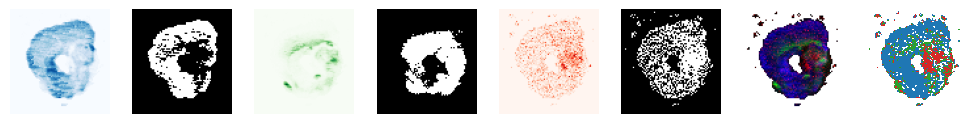

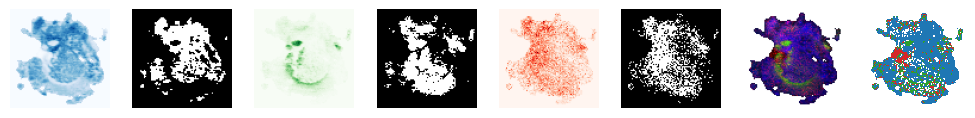

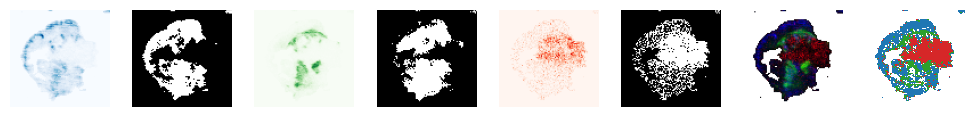

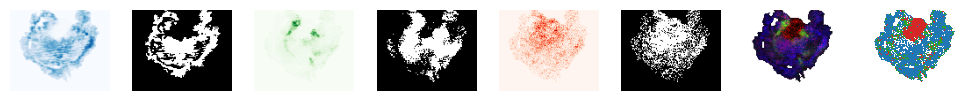

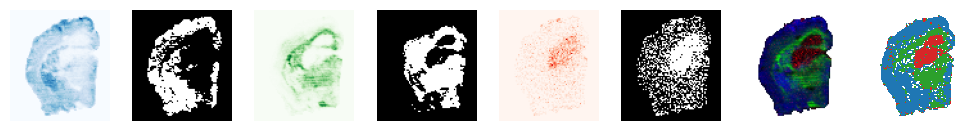

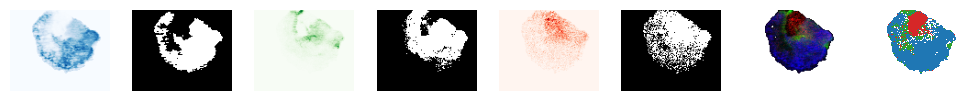

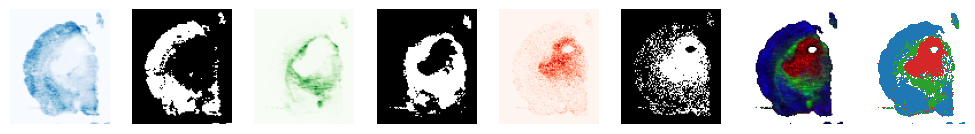

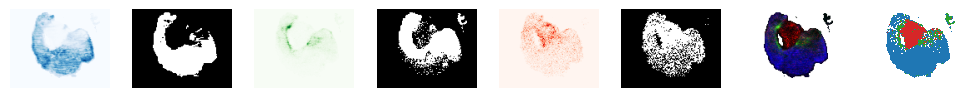

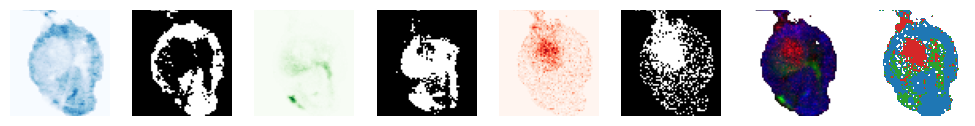

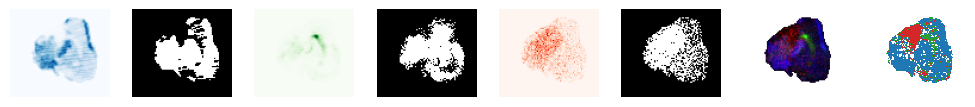

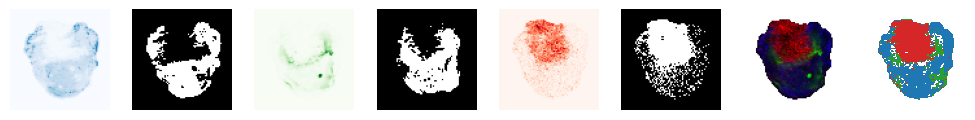

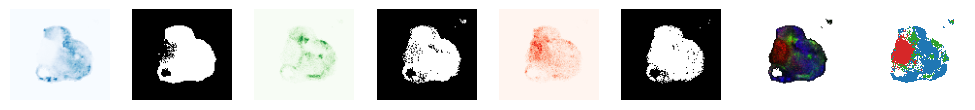

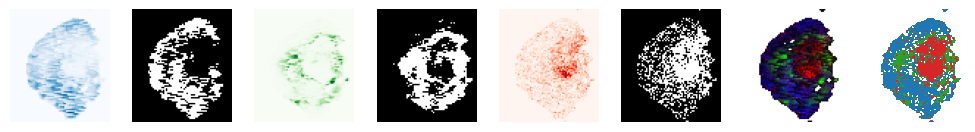

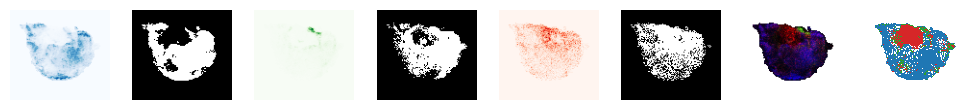

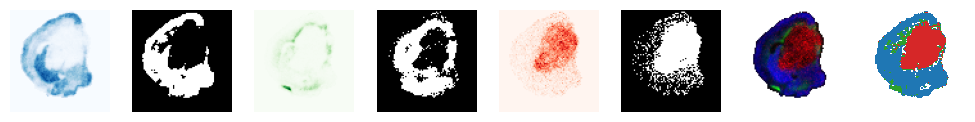

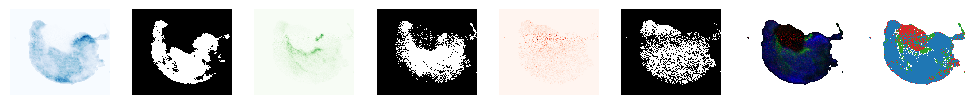

In [7]:
thresh_gray_matter = 75
thresh_white_matter = 75
thresh_tumour = 75

cluster_labels_map = {"gray_matter": 1, "white_matter": 2, "tumour": 3}

cmap = ListedColormap(["white", "tab:blue", "tab:green", "tab:red"])

gray_matter_mzs_filter = (
    (mzs_list[0][mzs_above_threshold_intersection] >= 600.51 - 0.025) &
    (mzs_list[0][mzs_above_threshold_intersection] <= 600.51 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0][mzs_above_threshold_intersection] >= 888.62 - 0.025) &
    (mzs_list[0][mzs_above_threshold_intersection] <= 888.62 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0][mzs_above_threshold_intersection] >= 682.64 - 0.025) &
    (mzs_list[0][mzs_above_threshold_intersection] <= 682.64 + 0.025)
)

cluster_labels_list = []

for idx, (img, seg) in enumerate(zip(img_original_list, seg_list)):
  values = img[seg][:, mzs_above_threshold_intersection]
  norm_values = MinMaxScaler(clip=True).fit_transform(values)
  norm_img = np.zeros([*img.shape[:-1], mzs_above_threshold_intersection.sum()])
  norm_img[seg] = norm_values

  gray_matter_img = norm_img[:, :, gray_matter_mzs_filter].mean(axis=-1)
  white_matter_img = norm_img[:, :, white_matter_mzs_filter].mean(axis=-1)
  tumour_img = norm_img[:, :, tumour_mzs_filter].mean(axis=-1)

  overlay_image = np.stack(
      (tumour_img, white_matter_img, gray_matter_img), axis=-1
  )
  overlay_image[~seg] = 1

  gray_matter_img_thresh = gray_matter_img >= np.percentile(
      gray_matter_img, thresh_gray_matter
  )
  white_matter_img_thresh = white_matter_img >= np.percentile(
      white_matter_img, thresh_white_matter
  )
  tumour_img_thresh = tumour_img >= np.percentile(tumour_img, thresh_tumour)

  clusters_img = np.zeros_like(gray_matter_img)
  clusters_img[gray_matter_img_thresh & ~white_matter_img_thresh &
               ~tumour_img_thresh] = cluster_labels_map["gray_matter"]
  clusters_img[~gray_matter_img_thresh & white_matter_img_thresh &
               ~tumour_img_thresh] = cluster_labels_map["white_matter"]
  clusters_img[~gray_matter_img_thresh & ~white_matter_img_thresh &
               tumour_img_thresh] = cluster_labels_map["tumour"]

  # Identify pixels that are still unclassified
  unclassified = (clusters_img == 0) & seg
  max_channel = np.stack(
      (gray_matter_img, white_matter_img, tumour_img), axis=-1
  )
  max_values = max_channel.max(axis=-1)
  second_max_values = np.partition(max_channel, -2, axis=-1)[:, :, -2]

  significant_diff = max_values >= 1.2 * second_max_values

  gray_matter_max = (
      gray_matter_img == max_values
  ) & significant_diff & unclassified
  white_matter_max = (
      white_matter_img == max_values
  ) & significant_diff & unclassified
  tumour_max = (tumour_img == max_values) & significant_diff & unclassified

  clusters_img[gray_matter_max] = cluster_labels_map["gray_matter"]
  clusters_img[white_matter_max] = cluster_labels_map["white_matter"]
  clusters_img[tumour_max] = cluster_labels_map["tumour"]

  vmin = min(gray_matter_img.min(), white_matter_img.min(), tumour_img.min())
  vmax = max(gray_matter_img.max(), white_matter_img.max(), tumour_img.max())

  fig, axes = plt.subplots(1, 8, figsize=(10,10))

  axes[0].imshow(gray_matter_img, vmin=vmin, vmax=vmax, cmap='Blues')
  axes[1].imshow(gray_matter_img_thresh, vmin=vmin, vmax=vmax, cmap='gray')
  axes[2].imshow(white_matter_img, vmin=vmin, vmax=vmax, cmap='Greens')
  axes[3].imshow(white_matter_img_thresh, vmin=vmin, vmax=vmax, cmap='gray')
  axes[4].imshow(tumour_img, vmin=vmin, vmax=vmax, cmap='Reds')
  axes[5].imshow(tumour_img_thresh, vmin=vmin, vmax=vmax, cmap='gray')
  axes[6].imshow(overlay_image)
  axes[7].imshow(clusters_img, cmap=cmap)

  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[3].axis('off')
  axes[4].axis('off')
  axes[5].axis('off')
  axes[6].axis('off')
  axes[7].axis('off')

  plt.tight_layout()
  plt.savefig(Path("new_longitudinal") / f"{np.array(samples_groups).flatten()[idx]}.png", bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()

  cluster_labels_list.append(clusters_img)

[1. 2. 3.] [1533  392  435]
[1. 2. 3.] [2405  456  443]
[1. 2. 3.] [1264  524  942]
[1. 2. 3.] [2940  580  841]
[1. 2. 3.] [1822  995  466]
[1. 2. 3.] [2317  425  562]
[1. 2. 3.] [2366  913  928]
[1. 2. 3.] [2710  424  799]
[1. 2. 3.] [1295  415  423]
[1. 2. 3.] [1416  155  395]
[1. 2. 3.] [1342  316  905]
[1. 2. 3.] [1299  381  570]
[1. 2. 3.] [1218  449  648]
[1. 2. 3.] [2170  227  737]
[1. 2. 3.] [1541  234  926]
[1. 2. 3.] [2485  431  521]


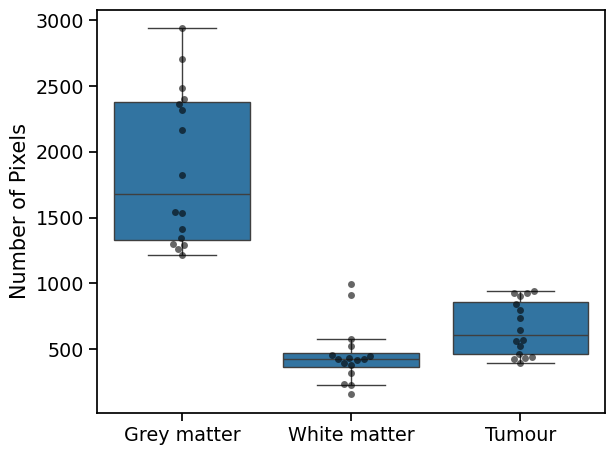

In [8]:
counts_all = {1: [], 2: [], 3: []}

for cluster_labels in cluster_labels_list:
  clusters, counts = np.unique(cluster_labels[cluster_labels != 0], return_counts=True)
  for cluster, count in zip(clusters, counts):
    counts_all[cluster].append(count)
  print(clusters, counts)

counts_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in counts_all.items()]))

counts_df.columns = ['Grey matter', 'White matter', 'Tumour']
long_counts_df = counts_df.melt(var_name='Tissue Type', value_name='Pixel Count')
sns.boxplot(x='Tissue Type', y='Pixel Count', data=long_counts_df, showfliers=False)
sns.swarmplot(x='Tissue Type', y='Pixel Count', data=long_counts_df, color='black', alpha=0.6)
plt.ylabel('Number of Pixels')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [9]:
def get_brain_id(name):
  return name.split("brain_")[1][0]


def get_treatment(name):
  return name.split("day_")[1].split("_")[1]


def get_day(name):
  return name.split("day_")[1][0]


p_values_all = {}

for idx in tqdm(range(0, len(img_original_list))):
  tumour_vectors = img_original_list[idx][cluster_labels_list[idx] ==
                                          cluster_labels_map.get("tumour")
                                         ][:, mzs_above_threshold_intersection]
  non_tumour_vectors = img_original_list[idx][
      cluster_labels_list[idx] != cluster_labels_map.get("tumour")
  ][:, mzs_above_threshold_intersection]
  sample_name = np.array(samples_groups).flatten()[idx]

  p_values = []
  for mz_idx, mz in enumerate(mzs_list[0][mzs_above_threshold_intersection]):
    t_stat_ind, p_value_ind = ttest_ind(
        tumour_vectors[:, mz_idx], non_tumour_vectors[:, mz_idx]
    )
    p_values.append(p_value_ind)

  _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')
  p_values_all[
      f"{get_brain_id(sample_name)}_{get_treatment(sample_name)}_{get_day(sample_name)}"
  ] = p_values_corrected

p_values_all = pd.DataFrame(
    p_values_all, index=mzs_list[0][mzs_above_threshold_intersection]
)
significant_tumour_mzs = p_values_all < 0.05

  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
# Get significant indexes by day and treatment
significant_not_treated_0 = np.ones(p_values_all.shape[0], dtype=bool)
significant_not_treated_5 = np.ones(p_values_all.shape[0], dtype=bool)
significant_treated_0 = np.ones(p_values_all.shape[0], dtype=bool)
significant_treated_5 = np.ones(p_values_all.shape[0], dtype=bool)
for column in significant_tumour_mzs:
  arr = significant_tumour_mzs[column].to_numpy()
  brain, treatment, day = column.split("_")

  if treatment == "0" and day == "0":
    significant_not_treated_0 &= arr
  elif treatment == "0" and day == "5":
    significant_not_treated_5 &= arr
  elif treatment == "1000" and day == "0":
    significant_treated_0 &= arr
  elif treatment == "1000" and day == "5":
    significant_treated_5 &= arr
  else:
    print("Error")

lipids_significant_change_df_all = []

# Indexes that are significant at Day 0 (both for treated and not treated) but
# become non-significant at Day 5 (for both treated and not treated), which
# means they change from significant to non-significant due to the passage of
# time only.
became_not_significant_due_to_time = (
    (significant_not_treated_0 & significant_treated_0) &
    ~(significant_not_treated_5 & significant_treated_5)
)

# Indexes that are not significant at Day 0 (both for treated and not treated)
# but become significant at Day 5 (for both treated and not treated), which
# means they change from non-significant to significant due to the passage of
# time only.
became_significant_due_to_time = (
    ~(significant_not_treated_0 & significant_treated_0) &
    (significant_not_treated_5 & significant_treated_5)
)

# Indexes that are not significant at Day 0 (both for treated and not treated)
# and at Day 5 (for both treated and not treated), which means they dont change
# due to the passage of time only.
stayed_non_significant_through_time = (
    (~significant_not_treated_0 & ~significant_not_treated_5) &
    (~significant_treated_0 & ~significant_treated_5)
)

# Indexes that are significant at Day 0 (both for treated and not treated)
# and at Day 5 (for both treated and not treated), which means they dont change
# due to the passage of time only.
stayed_significant_through_time = (
    significant_not_treated_0 & significant_treated_0 &
    significant_not_treated_5 & significant_treated_5
)

# Indexes that are significant at Day 0 (both for treated and not treated)
# and at Day 5 for not treated only, which means they could have change from
# due significant to non-significant due to treatment
could_have_become_not_significant_due_to_treatment = (
    significant_treated_0 & ~significant_treated_5 &
    ~became_not_significant_due_to_time
)

# Indexes that are not significant at Day 0 (both for treated and not treated)
# and at Day 5 for not treated only, which means they could have change from
# due non-significant to significant due to treatment
could_have_become_significant_due_to_treatment = (
    ~significant_treated_0 & significant_treated_5 &
    ~became_significant_due_to_time
)

# Check no overlap in the conditions
conditions = [
    ("became_not_significant_due_to_time", became_not_significant_due_to_time),
    ("became_significant_due_to_time", became_significant_due_to_time),
    (
        "stayed_non_significant_through_time",
        stayed_non_significant_through_time
    ),
    ("stayed_significant_through_time", stayed_significant_through_time),
    (
        "could_have_become_not_significant_due_to_treatment",
        could_have_become_not_significant_due_to_treatment
    ),
    (
        "could_have_become_significant_due_to_treatment",
        could_have_become_significant_due_to_treatment
    ),
]

for i, (name1, cond1) in enumerate(conditions):
  for name2, cond2 in conditions[i + 1:]:
    intersection = (cond1 & cond2).sum()
    if intersection > 0:
      print(
          f"Intersection found between {name1} and {name2}: {intersection} indexes"
      )

# Create list of reasons for significant changes
lipids_significant_changes_reason = np.array(
    ["other"] * p_values_all.shape[0], dtype=object
)
for name, bool_idx in conditions:
  lipids_significant_changes_reason[bool_idx] = name

significant_tumour_mzs[f"changes_reason"] = lipids_significant_changes_reason

significant_tumour_mzs.groupby("changes_reason").size()

changes_reason
became_not_significant_due_to_time                     98
became_significant_due_to_time                        630
could_have_become_not_significant_due_to_treatment    230
could_have_become_significant_due_to_treatment         16
other                                                 404
stayed_non_significant_through_time                    92
stayed_significant_through_time                       515
dtype: int64

In [11]:
interesting_mzs = significant_tumour_mzs[significant_tumour_mzs["changes_reason"] ==
                       "could_have_become_not_significant_due_to_treatment"].index
interesting_mzs_idx = np.isin(mzs_list[0], interesting_mzs)

In [12]:
diffs = []
for idx, (img, seg, cluster_labels) in enumerate(zip(
  img_original_list, seg_list, cluster_labels_list
)):
  # Look only on day 0
  if idx % 2 == 0:
    tumour_values = img[cluster_labels == 3][:, interesting_mzs_idx]
    non_tumour_values = img[cluster_labels != 3][:, interesting_mzs_idx]
    tumour_mean = tumour_values.mean(axis=0)
    non_tumour_mean = non_tumour_values.mean(axis=0)
    diffs.append(tumour_mean - non_tumour_mean)

In [13]:
interesting_tumour_mzs = interesting_mzs[np.mean(diffs, axis=0) > 0].to_numpy()

In [14]:
interesting_non_tumour_mzs = interesting_mzs[np.mean(diffs, axis=0) < 0].to_numpy()

In [15]:
non_unique_interesting_tumour_mzs = []

for mz in interesting_tumour_mzs:
  mz_filter = ((interesting_non_tumour_mzs >= mz - 0.025) & (interesting_non_tumour_mzs <= mz + 0.025))
  if mz_filter.sum() > 0:
      non_unique_interesting_tumour_mzs.append(mz)

non_unique_interesting_tumour_mzs

[888.53125]

In [16]:
non_unique_interesting_non_tumour_mzs = []

for mz in interesting_non_tumour_mzs:
  mz_filter = ((interesting_tumour_mzs >= mz - 0.025) & (interesting_tumour_mzs <= mz + 0.025))
  if mz_filter.sum() > 0:
      non_unique_interesting_non_tumour_mzs.append(mz)

non_unique_interesting_non_tumour_mzs

[888.51875]

In [17]:
interesting_tumour_mzs = interesting_tumour_mzs[interesting_tumour_mzs != non_unique_interesting_tumour_mzs]
interesting_non_tumour_mzs = interesting_non_tumour_mzs[interesting_non_tumour_mzs != non_unique_interesting_non_tumour_mzs]

In [18]:
len(interesting_tumour_mzs)

156

In [23]:
print(*interesting_tumour_mzs, sep=", ")

604.49375, 605.53125, 612.48125, 614.49375, 614.53125, 615.54375, 616.50625, 627.50625, 628.50625, 628.56875, 629.54375, 629.55625, 630.53125, 630.55625, 631.54375, 631.55625, 655.56875, 722.50625, 746.49375, 746.54375, 757.58125, 762.54375, 762.56875, 762.58125, 764.50625, 769.49375, 774.48125, 774.51875, 779.54375, 781.46875, 790.59375, 790.60625, 790.61875, 791.60625, 792.59375, 794.50625, 795.63125, 798.51875, 805.46875, 805.49375, 805.53125, 806.46875, 806.60625, 807.46875, 812.50625, 813.51875, 818.65625, 819.65625, 820.64375, 820.65625, 822.46875, 823.48125, 827.58125, 829.48125, 831.55625, 833.56875, 838.50625, 838.51875, 839.54375, 840.50625, 840.53125, 840.54375, 841.53125, 842.61875, 842.63125, 843.59375, 843.60625, 844.51875, 844.53125, 844.60625, 845.60625, 845.61875, 846.69375, 847.61875, 847.69375, 848.55625, 848.68125, 850.48125, 850.49375, 850.50625, 850.53125, 850.66875, 850.68125, 851.48125, 851.51875, 851.53125, 851.55625, 853.55625, 853.56875, 854.48125, 854.56875,

In [20]:
len(interesting_non_tumour_mzs)

72

In [24]:
print(*interesting_non_tumour_mzs, sep=", ")

600.51875, 600.53125, 600.54375, 601.53125, 602.51875, 602.53125, 602.54375, 602.55625, 603.51875, 748.49375, 760.50625, 765.56875, 765.58125, 765.59375, 790.54375, 790.55625, 791.53125, 791.54375, 791.55625, 791.56875, 808.68125, 813.66875, 824.65625, 824.66875, 824.68125, 825.65625, 825.66875, 826.66875, 826.68125, 826.69375, 827.68125, 827.69375, 834.54375, 834.66875, 836.65625, 837.63125, 837.65625, 837.66875, 856.51875, 858.65625, 860.68125, 860.69375, 861.64375, 861.66875, 862.68125, 862.69375, 862.70625, 863.63125, 863.68125, 863.70625, 864.66875, 864.68125, 865.64375, 865.65625, 865.66875, 865.68125, 866.65625, 866.66875, 877.66875, 884.64375, 889.68125, 890.68125, 890.69375, 891.66875, 891.68125, 892.63125, 892.64375, 892.65625, 892.66875, 893.64375, 893.65625, 893.66875


156

In [40]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [
            MinMaxScaler(clip=True).fit_transform(
                img[seg][:, mzs_above_threshold_intersection]
            ) for img, seg in zip(img_original_list, seg_list)
        ]
    )
)

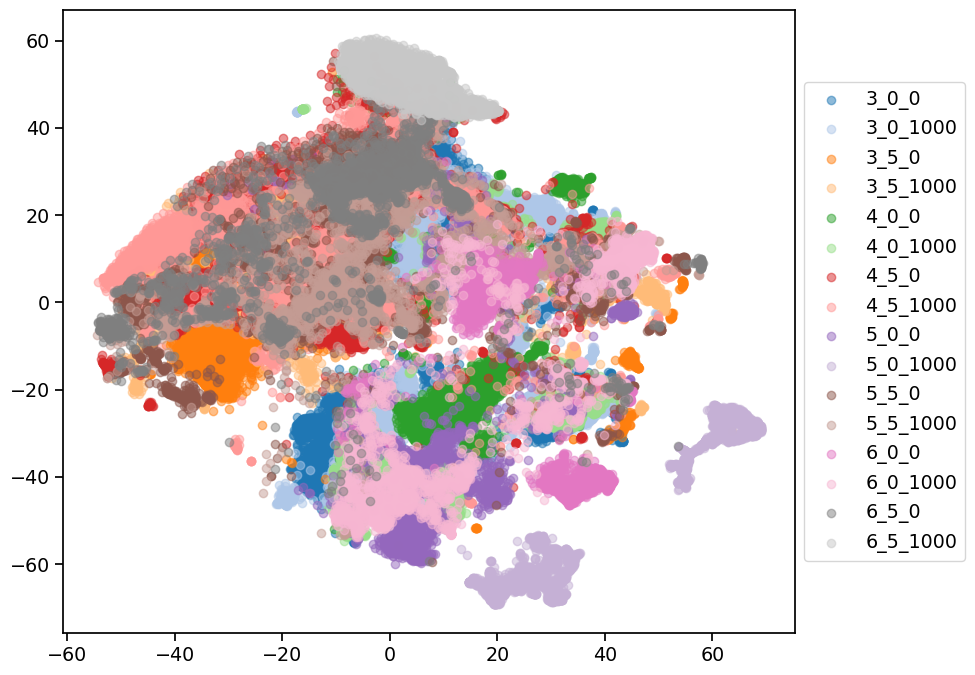

In [44]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [f"{get_brain_id(np.array(samples_groups).flatten()[i])}_{get_day(np.array(samples_groups).flatten()[i])}_{get_treatment(np.array(samples_groups).flatten()[i])}"] * img[seg].shape[0]
            for i, (img, seg) in enumerate(zip(img_original_list, seg_list))
        ]
    )
)

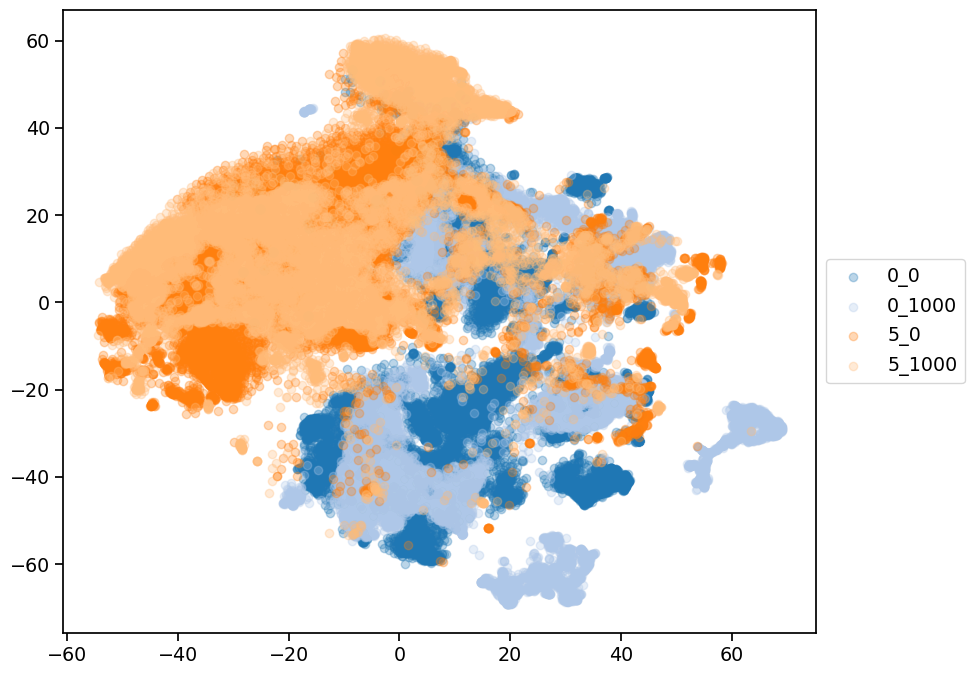

In [47]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [f"{get_day(np.array(samples_groups).flatten()[i])}_{get_treatment(np.array(samples_groups).flatten()[i])}"] * img[seg].shape[0]
            for i, (img, seg) in enumerate(zip(img_original_list, seg_list))
        ]
    )
)

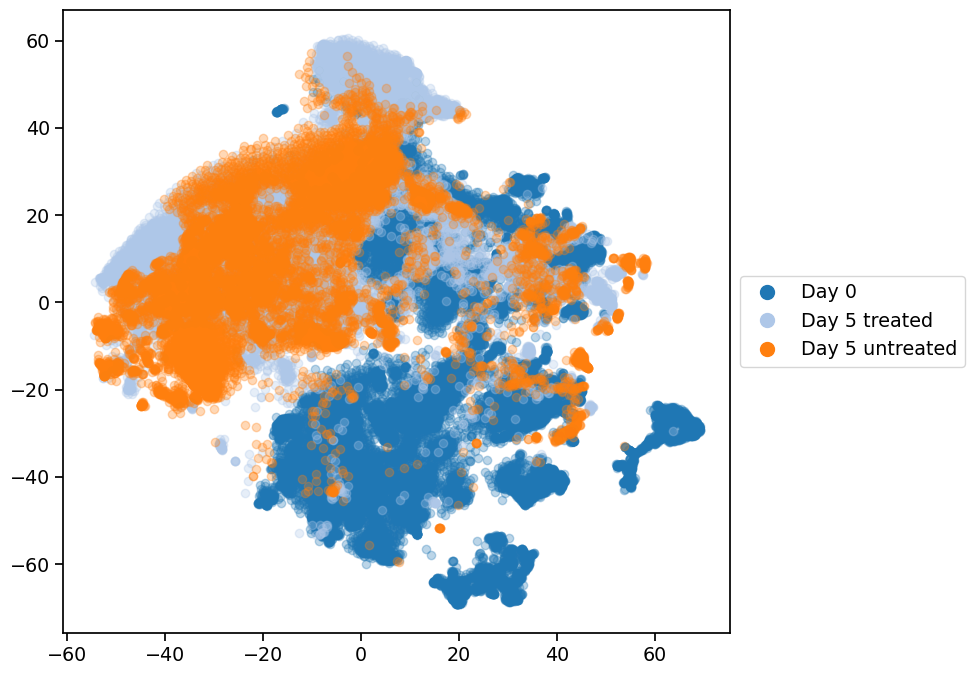

In [54]:
labels = []
for i, (img, seg) in enumerate(zip(img_original_list, seg_list)):
  sample_name = np.array(samples_groups).flatten()[i]
  brain_id, treatment, day = get_brain_id(sample_name), get_treatment(sample_name), get_day(sample_name) 
  if day == "0": 
    labels.extend(["Day 0"] * img[seg].shape[0])
  else:
    if treatment == "0":
      labels.extend(["Day 5 untreated"] * img[seg].shape[0])
    else:
      labels.extend(["Day 5 treated"] * img[seg].shape[0])

plot_embeddings(tsne_result, labels)

In [65]:
tsne_2 = TSNE(n_components=2, random_state=42)
tsne_result_2 = tsne_2.fit_transform(
    np.concatenate(
        [
            MinMaxScaler(clip=True).fit_transform(
                img[seg][:, mzs_above_threshold_intersection]
            )[(cluster_labels == cluster_labels_map.get("tumour"))[seg]] for img, seg, cluster_labels in zip(img_original_list, seg_list, cluster_labels_list)
        ]
    )
)

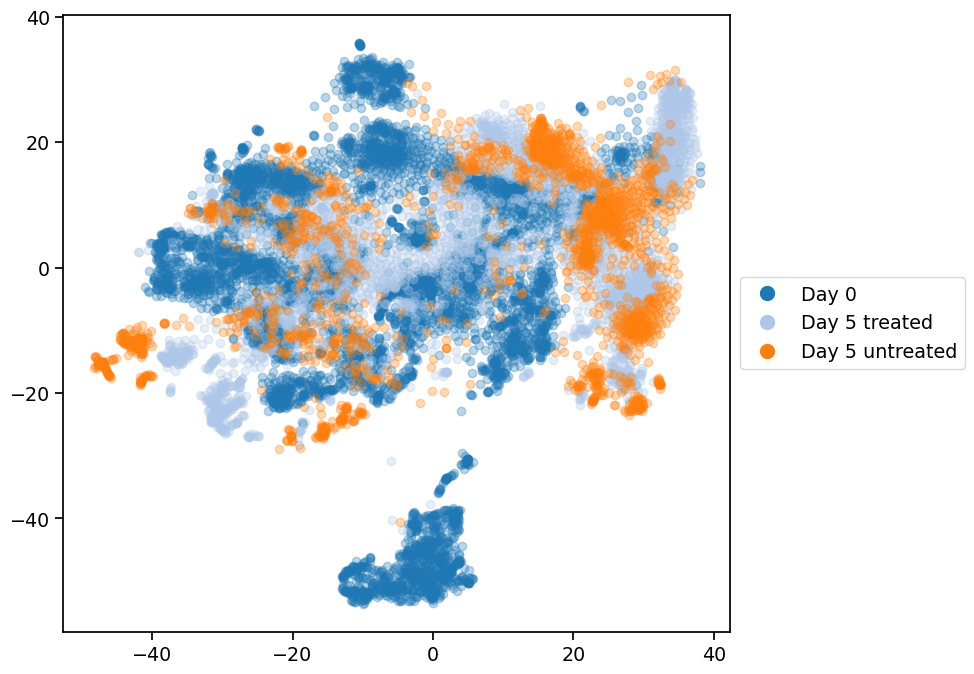

In [67]:
labels = []
for i, (img, seg, cluster_labels) in enumerate(zip(img_original_list, seg_list, cluster_labels_list)):
  sample_name = np.array(samples_groups).flatten()[i]
  brain_id, treatment, day = get_brain_id(sample_name), get_treatment(sample_name), get_day(sample_name) 
  if day == "0": 
    labels.extend(["Day 0"] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0])
  else:
    if treatment == "0":
      labels.extend(["Day 5 untreated"] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0])
    else:
      labels.extend(["Day 5 treated"] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0])

plot_embeddings(tsne_result_2, labels)

In [68]:
tsne_3 = TSNE(n_components=2, random_state=42)
tsne_result_3 = tsne_2.fit_transform(
    np.concatenate(
        [
            MinMaxScaler(clip=True).fit_transform(
                img[seg][:, mzs_above_threshold_intersection]
            )[(cluster_labels != cluster_labels_map.get("tumour"))[seg]] for img, seg, cluster_labels in zip(img_original_list, seg_list, cluster_labels_list)
        ]
    )
)

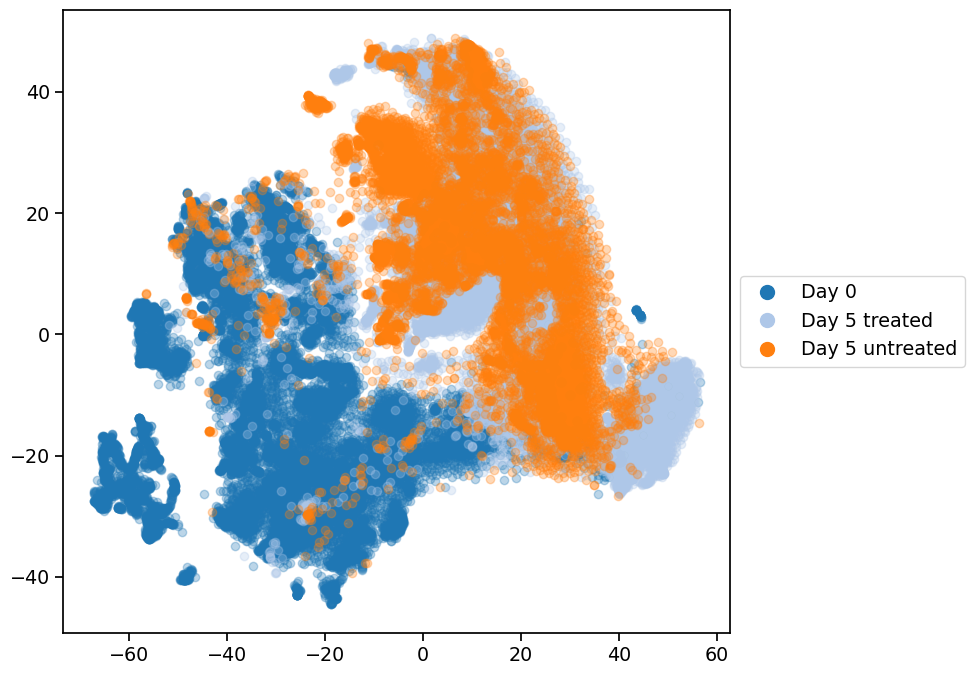

In [72]:
labels = []
for i, (img, seg, cluster_labels) in enumerate(zip(img_original_list, seg_list, cluster_labels_list)):
  sample_name = np.array(samples_groups).flatten()[i]
  brain_id, treatment, day = get_brain_id(sample_name), get_treatment(sample_name), get_day(sample_name) 
  if day == "0": 
    labels.extend(["Day 0"] * img[(cluster_labels != cluster_labels_map.get("tumour")) & seg].shape[0])
  else:
    if treatment == "0":
      labels.extend(["Day 5 untreated"] * img[(cluster_labels != cluster_labels_map.get("tumour")) & seg].shape[0])
    else:
      labels.extend(["Day 5 treated"] * img[(cluster_labels != cluster_labels_map.get("tumour")) & seg].shape[0])

plot_embeddings(tsne_result_3, labels)

In [70]:
tsne_result_3.shape

(41558, 2)

In [53]:
from sklearn.manifold import TSNE
import matplotlib.lines as mlines


def plot_embeddings(embeddings, labels):
  tab20_cmap = plt.get_cmap('tab20')
  selected_colors = [tab20_cmap(i) for i in range(20)]

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(embeddings, columns=['Component 1', 'Component 2'])
  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for idx, label in enumerate(sorted(df_tsne['Label'].unique())):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'], subset['Component 2'], label=label,
        color=selected_colors[idx], alpha=0.3
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  legend_handles = [
        mlines.Line2D(
            [], [], color=selected_colors[idx], marker='o', linestyle='None', markersize=10, label=label
        ) for idx, label in enumerate(sorted(df_tsne['Label'].unique()))
    ]
  plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()

In [28]:
# Min-max or global minimax dont change the TSNE plot

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [
            MinMaxScaler(clip=True).fit_transform(
                img[cluster_labels == cluster_labels_map.get("tumour")][:, np.isin(mzs_list[0], interesting_tumour_mzs)]
            ) for img, seg, cluster_labels in zip(img_original_list, seg_list, cluster_labels_list)
        ]
    )
)

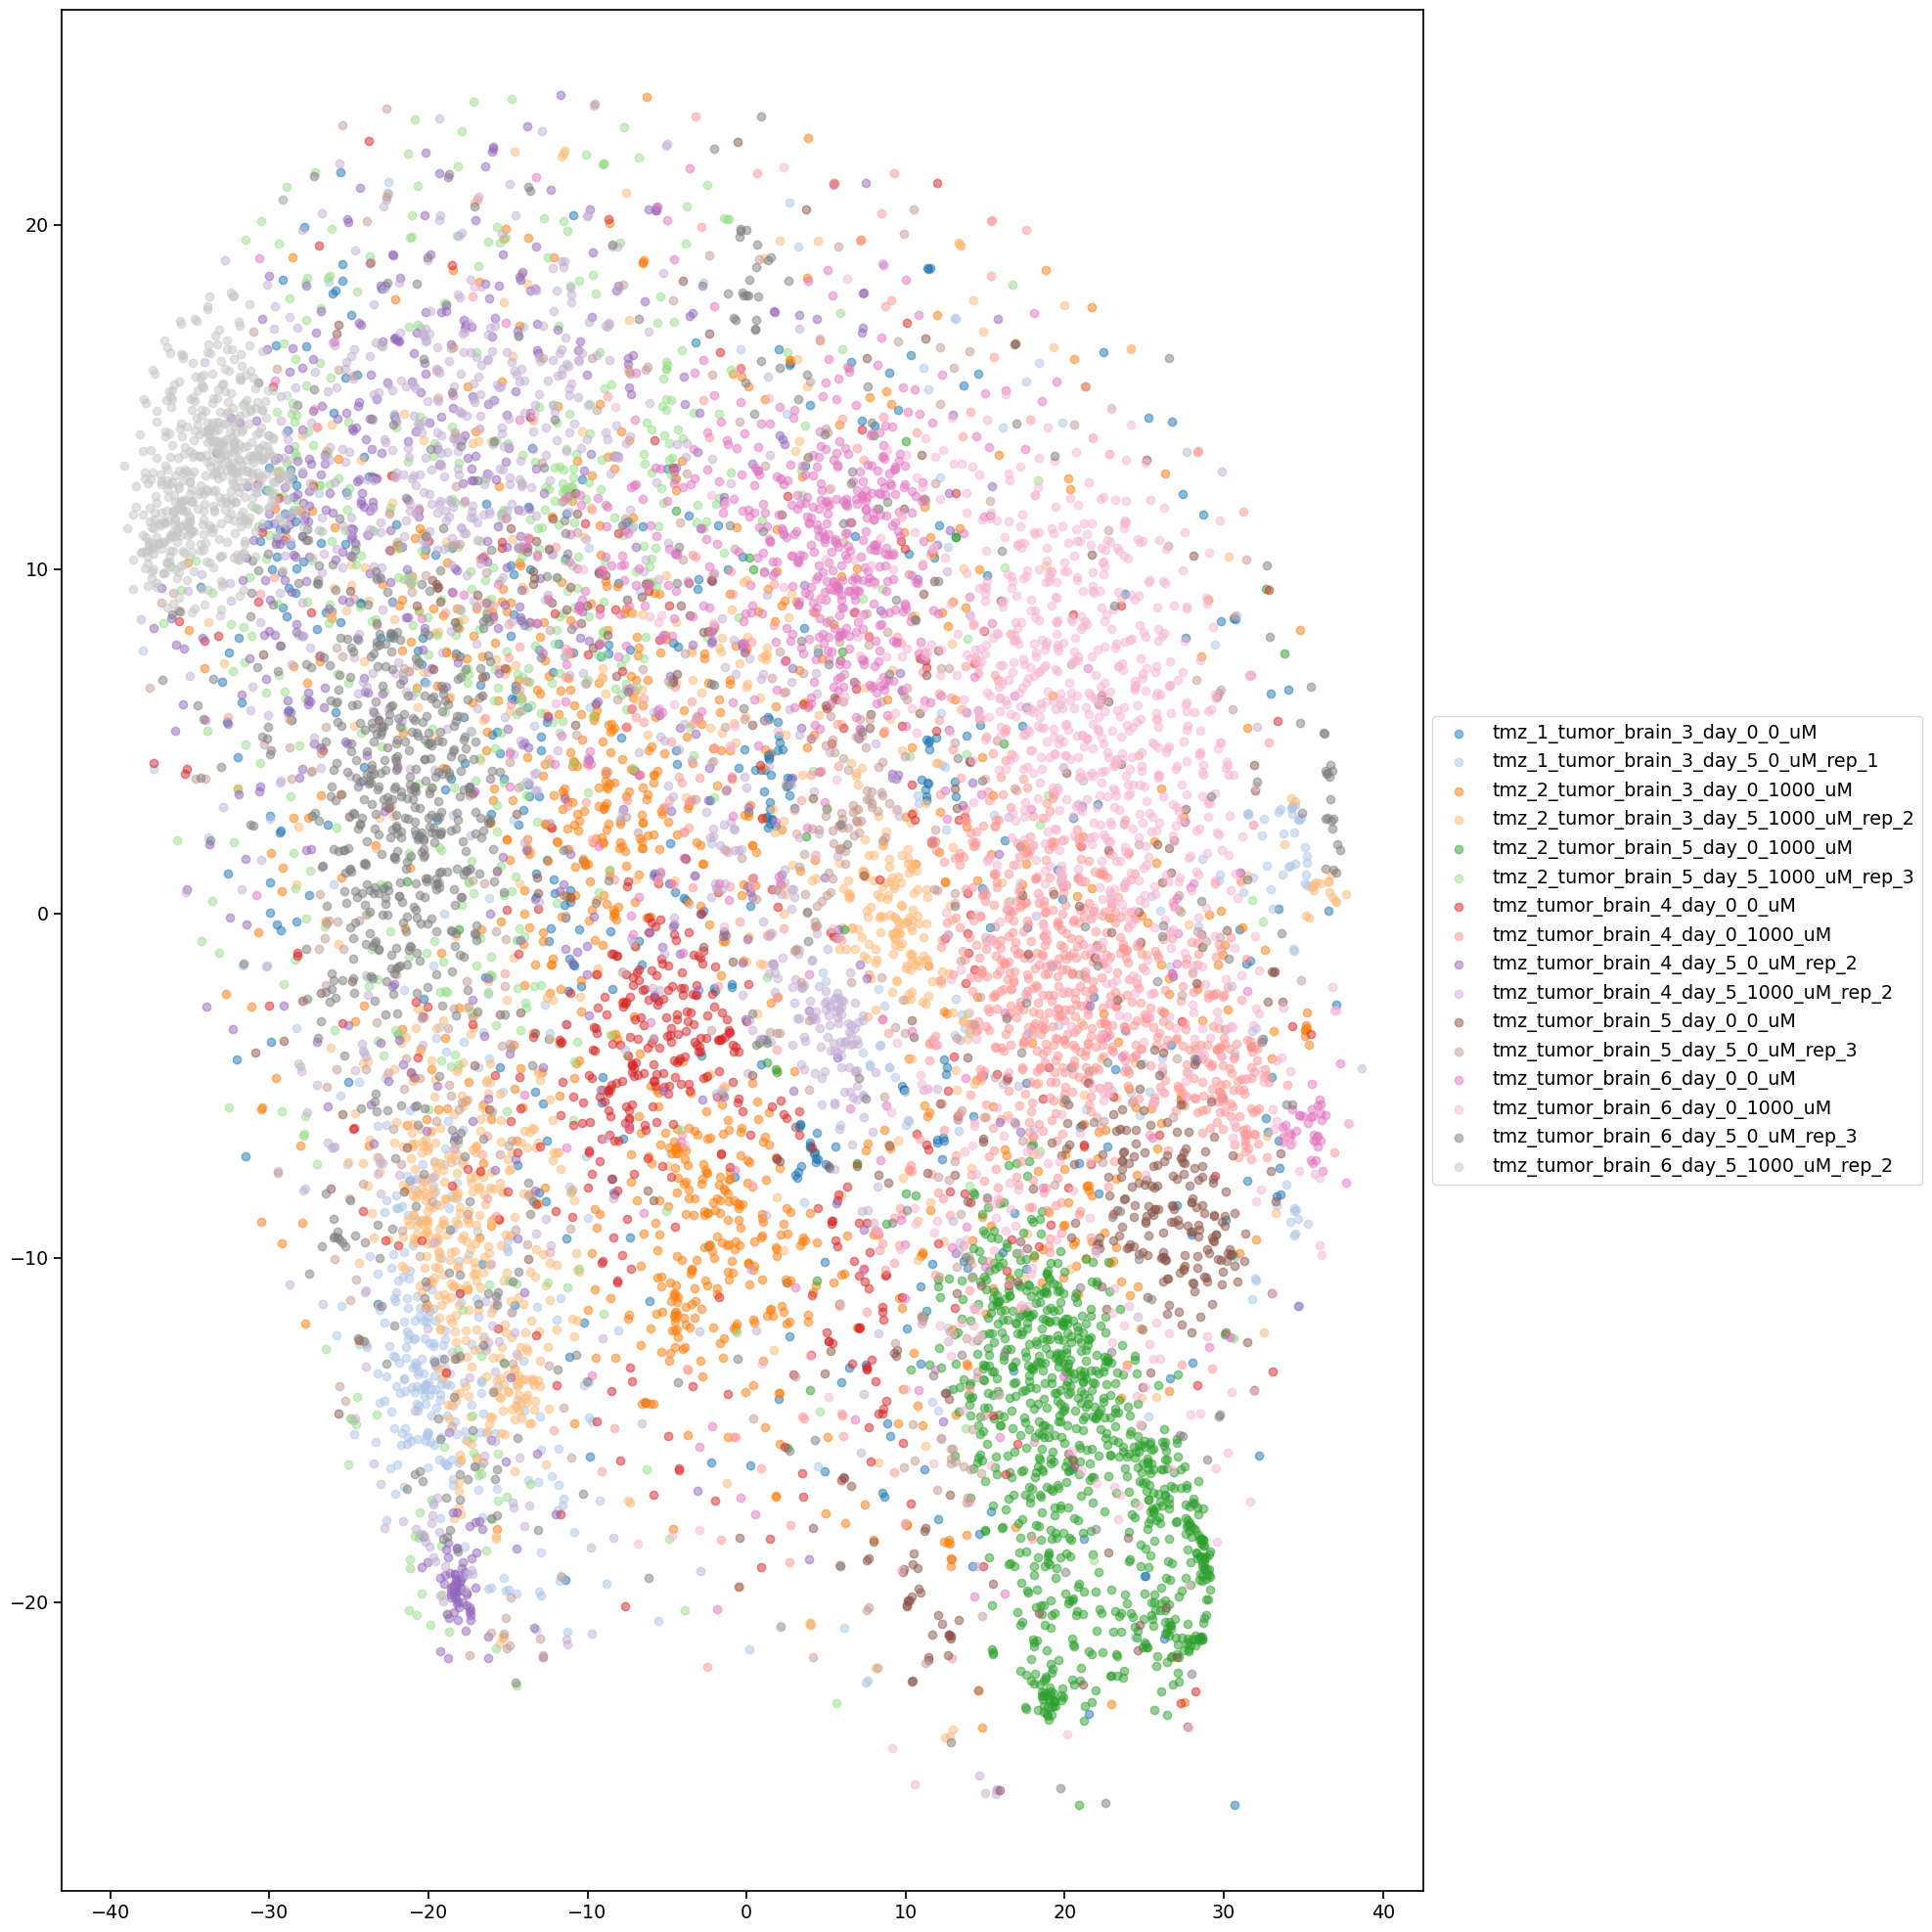

In [36]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [np.array(samples_groups).flatten()[i]] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0]
            for i, (img, seg, cluster_labels) in enumerate(zip(img_original_list, seg_list, cluster_labels_list))
        ]
    )
)

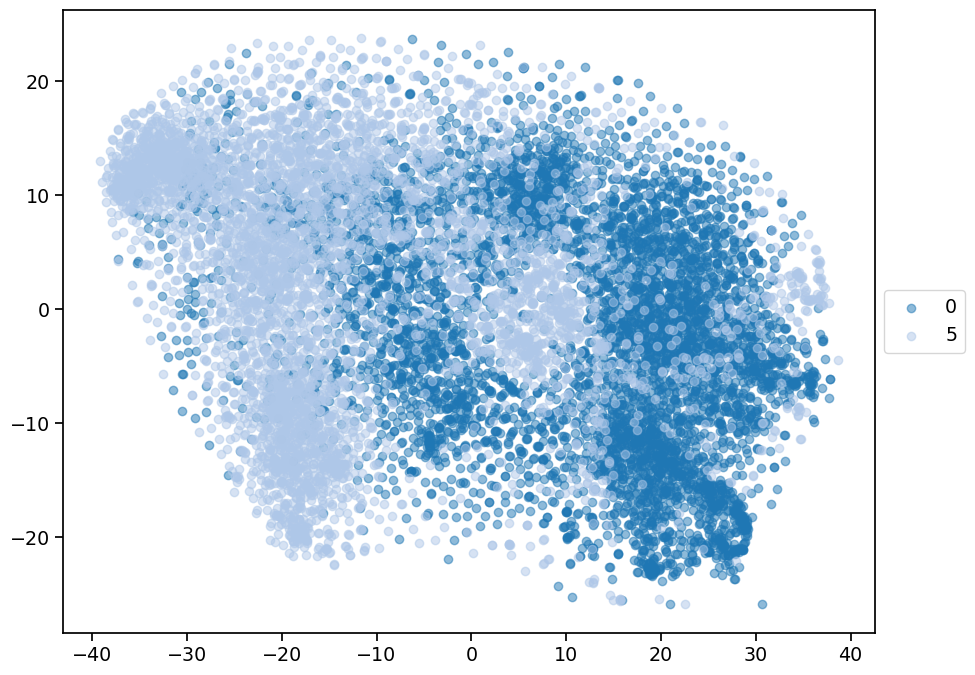

In [34]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [get_day(np.array(samples_groups).flatten()[i])] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0]
            for i, (img, seg, cluster_labels) in enumerate(zip(img_original_list, seg_list, cluster_labels_list))
        ]
    )
)

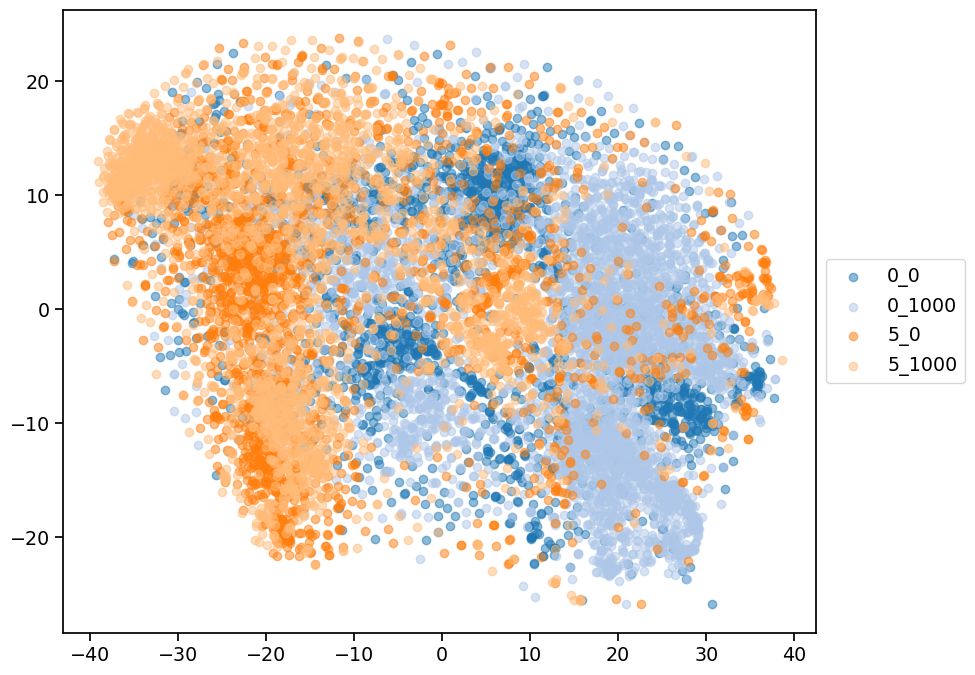

In [39]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [f"{get_day(np.array(samples_groups).flatten()[i])}_{get_treatment(np.array(samples_groups).flatten()[i])}"] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0]
            for i, (img, seg, cluster_labels) in enumerate(zip(img_original_list, seg_list, cluster_labels_list))
        ]
    )
)

In [ ]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [get_day(np.array(samples_groups).flatten()[i])] * img[cluster_labels == cluster_labels_map.get("tumour")].shape[0]
            for i, (img, seg, cluster_labels) in enumerate(zip(img_original_list, seg_list, cluster_labels_list))
        ]
    )
)

In [ ]:
correlations_0_treated= []
correlations_0_untreated= []
correlations_5_treated = []
correlations_5_untreated = []
for idx, (img, seg, cluster_labels) in enumerate(zip(
    img_original_list, seg_list, cluster_labels_list
  )):
  sample_name = np.array(samples_groups).flatten()[idx]
  brain, treatment, day = get_brain_id(sample_name), get_treatment(sample_name), get_day(sample_name)
  tumour_values = img[cluster_labels == 3][:, interesting_mzs_idx][:, np.mean(diffs, axis=0) > 0]
  tumour_img = img[cluster_labels == 3][:, mzs_above_threshold_intersection][:, tumour_mzs_filter].mean(axis=-1)
  corr_matrix = np.corrcoef(tumour_img, tumour_values.T)
  corr = corr_matrix[0, 1:]
  print(treatment)
  if idx % 2 == 0:
    if treatment == "0":
      correlations_0_untreated.append(corr)
    else:
      correlations_0_treated.append(corr)
  else:
    if treatment == "0":
      correlations_5_untreated.append(corr)
    else:
      correlations_5_treated.append(corr)

In [ ]:
sample_name

In [ ]:
treatment

In [ ]:
len(correlations_0_untreated)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.plot([-1,1], [-1,1], linestyle="--", c="gray")
plt.scatter(np.mean(correlations_0_untreated, axis=0), np.mean(correlations_5_untreated, axis=0), label="no_treatment", c="tab:red", alpha=0.5)
plt.scatter(np.mean(correlations_0_treated, axis=0), np.mean(correlations_5_treated, axis=0), label="treatment", c="tab:green", alpha=0.5)

zoom_x = [-0.1, 0.4]
zoom_y = [-0.1, 0.4]

ax = plt.gca()
axins = inset_axes(ax, width="35%", height="35%", loc="lower right", borderpad=1)
axins.plot([-1, 1], [-1, 1], linestyle="--", c="gray")
axins.scatter(np.mean(correlations_0_untreated, axis=0), np.mean(correlations_5_untreated, axis=0), c="tab:red")
axins.scatter(np.mean(correlations_0_treated, axis=0), np.mean(correlations_5_treated, axis=0), c="tab:green", alpha=0.5)
axins.set_xlim(zoom_x)
axins.set_ylim(zoom_y)
axins.set_xticks([])
axins.set_yticks([])
rect = plt.Rectangle((zoom_x[0], zoom_y[0]), zoom_x[1] - zoom_x[0], zoom_y[1] - zoom_y[0],
                     edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()

In [ ]:
from scipy.stats import pearsonr

correlations = []
most_correlated_tumours_lipids = []

for img, seg, cluster_labels in zip(
    img_original_list, seg_list, cluster_labels_list
):
  tumour_values = img[cluster_labels == 3][:, mzs_above_threshold_intersection]
  tumour_img = tumour_values[:, tumour_mzs_filter].mean(axis=-1)
  corr_matrix = np.corrcoef(tumour_img, tumour_values.T)
  corr = corr_matrix[0, 1:]
  correlations.append(corr)
  most_correlated_tumours_lipids.append(
      set(np.argsort(np.abs(corr))[-100:][::-1])
  )

common_correlated_tumours_lipids = set.union(*most_correlated_tumours_lipids)

In [ ]:
significant_tumour_mzs[significant_tumour_mzs["changes_reason"] ==
                       "could_have_become_not_significant_due_to_treatment"]

# Issue here as the lipids differ between the two groups not necessarly mean they belong to tumour. Maybe we should looka t the correlation in day 0 and select by them?

In [ ]:
paper_mzs = [
    611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45,
    731.51, 757.53, 657.52, 773.52, 887.56, 659.50, 631.46
]

for mz in sorted(paper_mzs):
  filt = (significant_tumour_mzs.index
          >= mz - 0.1) & (significant_tumour_mzs.index <= mz + 0.1)
  print(mz)
  counts = significant_tumour_mzs[filt].groupby("changes_reason").size()
  counts.drop("other", errors="ignore", inplace=True)
  print(counts.idxmax())

In [ ]:
from sklearn.manifold import TSNE


def plot_embeddings(embeddings, labels):
  tab20_cmap = plt.get_cmap('tab20')
  selected_colors = [tab20_cmap(i) for i in range(20)]

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(embeddings, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for idx, label in enumerate(sorted(df_tsne['Label'].unique())):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'], subset['Component 2'], label=label,
        color=selected_colors[idx]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()


def global_minmax_normalize(data):
  """
    Apply global Min-Max normalization to a dataset.

    Parameters:
    data (numpy.ndarray): The input data to normalize, assumed to be 2D with shape (n_samples, n_features).

    Returns:
    numpy.ndarray: The globally normalized data.
    """
  # Flatten the data to find the global min and max
  flattened_data = data.flatten()
  global_min = np.min(flattened_data)
  global_max = np.max(flattened_data)

  # Apply global Min-Max normalization
  normalized_data = (data - global_min) / (global_max - global_min)

  return normalized_data


# Min-max or global minimax dont change the TSNE plot

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [
            global_minmax_normalize(
                img[seg][:, mzs_above_threshold_intersection]
            ) for img, seg in zip(img_list, seg_list)
        ]
    )
)
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [np.array(samples_groups).flatten()[i]] * img[seg].shape[0]
            for i, (img, seg) in enumerate(zip(img_list, seg_list))
        ]
    )
)

In [ ]:
import harmonypy as hm

# Prepare data
data = np.concatenate(
    [
        MinMaxScaler(clip=True).fit_transform(
            img[seg][:, mzs_above_threshold_intersection]
        ) for img, seg in zip(img_list, seg_list)
    ]
)

# Prepare batch labels
batch_labels = np.concatenate(
    [
        [np.array(samples_groups).flatten()[i]] * img[seg].shape[0]
        for i, (img, seg) in enumerate(zip(img_list, seg_list))
    ]
)
batch_labels_df = pd.DataFrame({'batch': batch_labels})

# Specify features to use (all features in this case)
vars_use = ['batch']

ho = hm.run_harmony(data.T, batch_labels_df, vars_use)

In [ ]:
corrected_data = ho.Z_corr.T

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(corrected_data)
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [np.array(samples_groups).flatten()[i]] * img[seg].shape[0]
            for i, (img, seg) in enumerate(zip(img_list, seg_list))
        ]
    )
)

In [ ]:
def get_day(name):
  return name.split("day_")[1][0]


plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [get_day(np.array(samples_groups).flatten()[i])] * img[seg].shape[0]
            for i, (img, seg) in enumerate(zip(img_list, seg_list))
        ]
    )
)

In [ ]:
pd.get_dummies(batch_labels_df[vars_use]).to_numpy().T

In [ ]:
gray_matter_mzs_filter = (
    (mzs_list[0][mzs_above_threshold_intersection] >= 600.51 - 0.025) &
    (mzs_list[0][mzs_above_threshold_intersection] <= 600.51 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0][mzs_above_threshold_intersection] >= 888.62 - 0.025) &
    (mzs_list[0][mzs_above_threshold_intersection] <= 888.62 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0][mzs_above_threshold_intersection] >= 682.64 - 0.025) &
    (mzs_list[0][mzs_above_threshold_intersection] <= 682.64 + 0.025)
)

for img, seg in zip(img_list, seg_list):

  gray_matter_img = img[:, :, mzs_above_threshold_intersection
                       ][:, :, gray_matter_mzs_filter].mean(axis=-1)
  white_matter_img = img[:, :, mzs_above_threshold_intersection
                        ][:, :, white_matter_mzs_filter].mean(axis=-1)
  tumour_img = img[:, :,
                   mzs_above_threshold_intersection][:, :,
                                                     tumour_mzs_filter].mean(
                                                         axis=-1
                                                     )

  vmin = min(gray_matter_img.min(), white_matter_img.min(), tumour_img.min())
  vmax = max(gray_matter_img.max(), white_matter_img.max(), tumour_img.max())

  fig, axes = plt.subplots(1, 3)

  im1 = axes[0].imshow(gray_matter_img, vmin=vmin, vmax=vmax, cmap='Blues')
  im2 = axes[1].imshow(white_matter_img, vmin=vmin, vmax=vmax, cmap='Greens')
  im3 = axes[2].imshow(tumour_img, vmin=vmin, vmax=vmax, cmap='Reds')

  axes[0].axis('off')
  axes[0].set_title('600.51 +- 0.025')
  axes[1].axis('off')
  axes[1].set_title('888.62 +- 0.025')
  axes[2].axis('off')
  axes[2].set_title('682.64 +- 0.025')

  plt.tight_layout()
  plt.show()

In [ ]:
def perform_hierarchical_clustering(pixels, n_clusters):
  # Perform hierarchical clustering
  clustering = AgglomerativeClustering(
      n_clusters=n_clusters, linkage='ward', compute_distances=True
  )
  clustering.fit(pixels)
  return clustering


load_models = False

save_path = Path("./longitudinal/new_new_method/common_mzs_hca_0")
save_path.mkdir(parents=True, exist_ok=True)

gaussian_sigma = 0
n_clusters = 3

cluster_labels_list = []

for sample_name, img, mzs, seg in zip(
    np.array(samples_groups).flatten(), img_original_list, mzs_list, seg_list
):
  if load_models:
    hca = joblib.load(save_path / f"{sample_name}.pkl")
  else:
    values = ndimage.gaussian_filter(img, sigma=gaussian_sigma
                                    )[seg][:, mzs_above_threshold_intersection]
    hca = perform_hierarchical_clustering(values, n_clusters)
    joblib.dump(hca, save_path / f"{sample_name}.pkl")

  cluster_labels = np.zeros(img.shape[:-1])
  cluster_labels[seg] = hca.labels_ + 1
  cluster_labels_list.append(cluster_labels)

  print(sample_name)
  plot_clusters(cluster_labels, n_clusters)

# Brain 6 no treatment 0 and 5 clustering is not that good
#

In [ ]:
# Computes and prints the mean cluster vectors filtered by predefined lipids
# (gray matter, white matter, and tumour) for each unique cluster. Determine if
# a cluster belongs to gray matter, white matter, or tumour by highest sum of
# the mean cluster vector elements.

for idx, (img, cluster_labels) in enumerate(zip(img_list, cluster_labels_list)):
  print(idx)
  for label in np.unique(cluster_labels):
    if label > 0:
      mean_cluster_vector = img[cluster_labels == label
                               ][:,
                                 mzs_above_threshold_intersection].mean(axis=0)
      for name, loop_filter in zip(
          ["gray_matter", "white_matter", "tumour"],
          [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
      ):
        print(
            label, name, mean_cluster_vector[loop_filter],
            mean_cluster_vector[loop_filter].sum(), sep=", "
        )

In [ ]:
from matplotlib.colors import ListedColormap, to_rgba

cluster_map = {
    0: {3: "Tumour", 2: "White matter", 1: "Gray matter"},
    1: {3: "Tumour", 2: "Gray matter", 1: "White matter"},
    2: {3: "Tumour", 2: "White matter", 1: "Gray matter"},
    3: {3: "White matter", 2: "Tumour", 1: "Gray matter"},
    4: {3: "Tumour", 2: "Gray matter", 1: "White matter"},
    5: {3: "White matter", 2: "Tumour", 1: "Gray matter"},
    6: {3: "Tumour", 2: "White matter", 1: "Gray matter"},
    7: {3: "Gray matter", 2: "White matter", 1: "Tumour"},
    8: {3: "Gray matter", 2: "Tumour", 1: "White matter"},
    9: {3: "Gray matter", 2: "White matter", 1: "Tumour"},
    10: {3: "Tumour", 2: "White matter", 1: "Gray matter"},
    11: {3: "Tumour", 2: "White matter", 1: "Gray matter"},
    12: {3: "White matter", 2: "Gray matter", 1: "Tumour"},
    13: {  # Problematic
        3: "White matter", 2: "Tumour", 1: "Gray matter"
    },
    14: {3: "White matter", 2: "Tumour", 1: "Gray matter"},
    15: {3: "Tumour", 2: "Gray matter", 1: "White matter"}
}


def new_plot_clusters(label_image, n_clusters=3):
  # Define the specific colors for the clusters
  cluster_colors = {1: 'tab:blue', 2: 'tab:green', 3: 'tab:red', 4: 'tab:gray'}

  # Create a list of colors with the custom specified colors for clusters 1, 2, and 3
  colors = [cluster_colors.get(i, 'gray') for i in range(1, n_clusters + 1)]
  colors = np.vstack(
      (
          [1, 1, 1, 1], [
              to_rgba(cluster_colors.get(i,
                                         plt.get_cmap('tab10')(i)))
              for i in range(1, n_clusters + 1)
          ]
      )
  )

  custom_cmap = ListedColormap(colors)

  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  cbar = plt.colorbar(
      seg_c_map, ticks=np.arange(1, n_clusters + 1),
      boundaries=np.arange(0.5, n_clusters + 1.5)
  )
  cbar.set_ticklabels(range(1, n_clusters + 1))
  cbar.set_label(
      'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
  )
  cbar.outline.set_edgecolor('0.2')
  cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
  for l in cbar.ax.get_yticklabels():
    l.set_fontweight('bold')
    l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


area_to_label = {"Tumour": 3, "White matter": 2, "Gray matter": 1}

new_cluster_labels_list = []
for idx, cluster_labels in enumerate(cluster_labels_list):
  new_cluster_labels = np.zeros(cluster_labels.shape)
  for label in np.unique(cluster_labels):
    if label > 0 and idx in cluster_map:
      new_cluster_labels[cluster_labels == label
                        ] = area_to_label[cluster_map[idx][label]]
  new_cluster_labels_list.append(new_cluster_labels)
  new_plot_clusters(new_cluster_labels, 3)

In [ ]:
unique_labels = list(range(1, 4))
for cluster_labels_idx in range(0, len(cluster_labels_list)):
  print(np.array(samples_groups).flatten()[cluster_labels_idx])
  for label_idx_i in range(0, len(unique_labels)):
    print(unique_labels[label_idx_i])
    values_i = img_list[cluster_labels_idx][
        cluster_labels_list[cluster_labels_idx] == unique_labels[label_idx_i]]
    print(sorted(mzs_list[0][np.argsort(values_i.mean(axis=0))[-50:][::-1]]))
  print()

In [ ]:
unique_labels = list(range(1, 4))
for cluster_labels_idx in range(0, len(cluster_labels_list)):
  print(np.array(samples_groups).flatten()[cluster_labels_idx])
  for label_idx_i in range(0, len(unique_labels)):
    for label_idx_j in range(label_idx_i + 1, len(unique_labels)):
      print(unique_labels[label_idx_i], unique_labels[label_idx_j])
      values_i = img_list[cluster_labels_idx][
          cluster_labels_list[cluster_labels_idx] == unique_labels[label_idx_i]]
      values_j = img_list[cluster_labels_idx][
          cluster_labels_list[cluster_labels_idx] == unique_labels[label_idx_j]]
      print(
          sorted(
              mzs_list[0][np.argsort(
                  np.abs(values_i.mean(axis=0) - values_j.mean(axis=0))
              )[-10:][::-1]]
          )
      )
  print()

In [ ]:
day_0_tumour_pixels = cluster_labels_list[0][]

In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

gaussian_sigma = 0.5

values_1 = ndimage.gaussian_filter(img_original_list[0], sigma=gaussian_sigma)[
    seg_list[0]][:, common_mzs_above_threshold]
values_2 = ndimage.gaussian_filter(img_original_list[1], sigma=gaussian_sigma)[
    seg_list[1]][:, common_mzs_above_threshold]

p_values = []
for mz_idx, mz in tqdm(enumerate(mzs_list[0][common_mzs_above_threshold])):
  t_stat_ind, p_value_ind = ttest_ind(values_1[:, mz_idx], values_2[:, mz_idx])
  p_values.append(p_value_ind)

In [ ]:
alpha = 0.01
_, p_values_corrected, _, _ = multipletests(
    p_values, method='fdr_bh', alpha=alpha
)

In [ ]:
mzs_list[0][common_mzs_above_threshold][np.array(p_values_corrected) > alpha
                                       ].shape

In [ ]:
mzs_list[0][common_mzs_above_threshold]

In [ ]:
gray_matter_mzs_filter = (
    (mzs_list[0][common_mzs_above_threshold] >= 600.51 - 0.025) &
    (mzs_list[0][common_mzs_above_threshold] <= 600.51 + 0.025)
)
gray_matter_mzs_filter.sum()

In [ ]:
gray_matter_mzs_filter = (
    (mzs_list[0][common_mzs_above_threshold] >= 600.51 - 0.025) &
    (mzs_list[0][common_mzs_above_threshold] <= 600.51 + 0.025)
)
gray_matter_mzs_filter.sum()

In [ ]:
gray_matter_mzs_filter = (
    (mzs_list[0][common_mzs_above_threshold] >= 600.51 - 0.025) &
    (mzs_list[0][common_mzs_above_threshold] <= 600.51 + 0.025)
)
gray_matter_mzs_filter.sum()

In [ ]:
gray_matter_mzs_filter = (
    (mzs_list[0][common_mzs_above_threshold] >= 600.51 - 0.025) &
    (mzs_list[0][common_mzs_above_threshold] <= 600.51 + 0.025)
)
gray_matter_mzs_filter.sum()

gray_matter_mzs_filter = (
    (mzs_list[0][common_mzs_above_threshold] >= 600.51 - 0.025) &
    (mzs_list[0][common_mzs_above_threshold] <= 600.51 + 0.025)
)
gray_matter_mzs_filter.sum()

gray_matter_mzs_filter = (
    (mzs_list[0][common_mzs_above_threshold] >= 600.51 - 0.025) &
    (mzs_list[0][common_mzs_above_threshold] <= 600.51 + 0.025)
)
gray_matter_mzs_filter.sum()

gray_matter_img = img_list[0][:, :, common_mzs_above_threshold
                             ][:, :, gray_matter_mzs_filter].mean(axis=-1)
white_matter_img = img_list[0][:, :, common_mzs_above_threshold
                              ][:, :, white_matter_mzs_filter].mean(axis=-1)
tumour_img = img_list[0][:, :,
                         common_mzs_above_threshold][:, :,
                                                     tumour_mzs_filter].mean(
                                                         axis=-1
                                                     )

vmin = min(gray_matter_img.min(), white_matter_img.min(), tumour_img.min())
vmax = max(gray_matter_img.max(), white_matter_img.max(), tumour_img.max())

fig, axes = plt.subplots(1, 3)

im1 = axes[0].imshow(gray_matter_img, vmin=vmin, vmax=vmax, cmap='Blues')
im2 = axes[1].imshow(white_matter_img, vmin=vmin, vmax=vmax, cmap='Greens')
im3 = axes[2].imshow(tumour_img, vmin=vmin, vmax=vmax, cmap='Reds')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(
    img_list[1][:, :, common_mzs_above_threshold][:, :,
                                                  gray_matter_mzs_filter].mean(
                                                      axis=-1
                                                  )
)
plt.show()
plt.imshow(
    img_list[1][:, :,
                common_mzs_above_threshold][:, :,
                                            tumour_mzs_filter].mean(axis=-1)
)
plt.show()
plt.imshow(
    img_list[1][:, :, common_mzs_above_threshold][:, :,
                                                  white_matter_mzs_filter].mean(
                                                      axis=-1
                                                  )
)
plt.show()

In [ ]:
hca_1 = perform_hierarchical_clustering(values_1, n_clusters)
hca_2 = perform_hierarchical_clustering(values_2, n_clusters)

In [ ]:
cluster_labels_1 = np.zeros(img_list[0].shape[:-1])
cluster_labels_1[seg_list[0]] = hca_1.labels_ + 1

cluster_labels_2 = np.zeros(img_list[1].shape[:-1])
cluster_labels_2[seg_list[1]] = hca_2.labels_ + 1

plot_clusters(cluster_labels_1, n_clusters)
plot_clusters(cluster_labels_2, n_clusters)

In [ ]:
unique_labels = np.unique(hca_1.labels_)
for label_idx in range(0, len(unique_labels)):
  for label_idx_2 in range(label_idx + 1, len(unique_labels)):
    print(unique_labels[label_idx] + 1, unique_labels[label_idx_2] + 1)
    print(
        np.argsort(
            np.abs(
                (
                    values_1[hca_1.labels_ == unique_labels[label_idx]
                            ].mean(axis=0)
                ) - (
                    values_1[hca_1.labels_ == unique_labels[label_idx_2]
                            ].mean(axis=0)
                )
            )
        )[-10:][::-1]
    )

In [ ]:
mzs_list[0][common_mzs_above_threshold][[
    1825, 1826, 1154, 534, 1846, 1028, 1824, 1421, 1422, 1191
]]

In [ ]:
mzs_list[0][common_mzs_above_threshold][[
    2, 1, 3, 1825, 17, 18, 11, 1421, 10, 1826
]]

In [ ]:
mzs_list[0][common_mzs_above_threshold][[
    1825, 1826, 1154, 1028, 1846, 1421, 1824, 534, 1422, 1029
]]

In [ ]:
# Check how many of the non different features are also significant in both images

In [ ]:
plt.hist(p_values_corrected)
plt.show()

In [ ]:
above_threshold = []

for sample_name, img, mzs, seg in zip(np.array(samples_groups).flatten(), img_list, mzs_list, seg_list):
  mean = 

In [ ]:
# look at pairs and try to understand why there lipids differ so much and what are the lipids that dont differ
#
# Look at the features in the data and see changes due to time\treatment
# Do HCA using significant features in all data


In [ ]:
gray_matter_mzs_filter = ((mzs >= 600.51 - 0.025) & (mzs <= 600.51 + 0.025))
tumour_mzs_filter = ((mzs >= 682.64 - 0.025) & (mzs <= 682.64 + 0.025))
white_matter_mzs_filter = ((mzs >= 888.62 - 0.025) & (mzs <= 888.62 + 0.025))

thresh_imgs = {}
for sample_name, mzs, img, seg in zip(
    np.array(samples_groups).flatten(), mzs_list, img_list, seg_list
):
  thresh_imgs[sample_name] = {}
  for color_map, name, loop_filter in zip(
      ["Blues", "Greens", "Reds"], ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    thresh_img = img[:, :, loop_filter].sum(
        axis=-1
    ) >= np.percentile(img[seg][:, loop_filter].sum(axis=-1), 50)
    thresh_imgs[sample_name][name] = thresh_img

In [ ]:
cluster_labels = {"gray_matter": 1, "white_matter": 2, "tumour": 3}
cluster_labels_maps = {}

for sample_name, t_imgs in thresh_imgs.items():
  gray_matter_mask = t_imgs["gray_matter"]
  white_matter_mask = t_imgs["white_matter"]
  tumour_mask = t_imgs["tumour"]

  cluster_labels_map = np.zeros_like(gray_matter_mask, dtype=int)
  cluster_labels_map[gray_matter_mask & ~white_matter_mask &
                     ~tumour_mask] = cluster_labels["gray_matter"]
  cluster_labels_map[~gray_matter_mask & white_matter_mask &
                     ~tumour_mask] = cluster_labels["white_matter"]
  cluster_labels_map[~gray_matter_mask & ~white_matter_mask &
                     tumour_mask] = cluster_labels["tumour"]
  print(np.unique(cluster_labels_map))
  plt.imshow(cluster_labels_map)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [ ]:
img[seg][:, gray_matter_mzs_filter].mean(axis=-1).shape

In [ ]:
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

mzs_filter = gray_matter_mzs_filter | tumour_mzs_filter | white_matter_mzs_filter

for img in img_list:
  for color_map, name, loop_filter in zip(
      ["Blues", "Greens", "Reds"], ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    plot_img = img[:, :, loop_filter].mean(axis=-1)
    plt.imshow(plot_img, cmap=color_map)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
common_mzs_above_threshold = np.logical_and.reduce(above_threshold)

In [ ]:
a = True
for img, seg in zip(img_list, seg_list):
  mean_vec = np.mean(img[seg], axis=0)
  a &= (mean_vec >= np.median(mean_vec))
  print(np.median(mean_vec))

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [
            img[seg][:, common_mzs_above_threshold]
            for img, seg in zip(img_list, seg_list)
        ]
    )
)

In [ ]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [sample_name] * img[seg].shape[0] for img, seg, sample_name in
            zip(img_list, seg_list,
                np.array(samples_groups).flatten())
        ]
    )
)

In [ ]:
len(
    [
        [sample_name] * img[seg].shape[0] for img, seg, sample_name in
        zip(img_list, seg_list,
            np.array(samples_groups).flatten())
    ]
)

In [ ]:
for label in area_to_label.keys():
  tsne_data = []
  tsne_labels = []

  for img, cluster_labels, sample_name in zip(
      img_no_spatial_smoothing_list, new_cluster_labels_list,
      np.array(samples_groups).flatten()
  ):
    tsne_data.append(img[cluster_labels == area_to_label.get(label)])
    if get_day(sample_name) == "0":
      tsne_labels.extend(
          ["Day 0"] * img[cluster_labels == area_to_label.get(label)].shape[0]
      )
    elif get_day(sample_name) == "5" and get_treatment(sample_name) == "0":
      tsne_labels.extend(
          ["Day 5 Untreated"] *
          img[cluster_labels == area_to_label.get(label)].shape[0]
      )
    else:
      tsne_labels.extend(
          ["Day 5 Treated"] *
          img[cluster_labels == area_to_label.get(label)].shape[0]
      )

  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(np.concatenate(tsne_data))
  print(label)


In [ ]:
for mz in [600.51, 682.64, 888.62]:
  print(mz)
  for img, seg in zip(img_list, seg_list):
    mzs_filter = ((mzs_list[0] >= mz - 0.025) & (mzs_list[0] <= mz + 0.025))
    print(np.mean(img[seg], axis=0)[mzs_filter].mean(axis=-1))

In [ ]:
common_mzs_above_threshold.sum()

In [ ]:
mzs

In [ ]:
mzs = mzs_list[0][a]

mzs[(mzs >= 888.62 - 0.025) & (mzs <= 888.62 + 0.025)]

In [ ]:
img_no_spatial_smoothing_list = []

for img, seg in zip(img_original_list, seg_list):
  img[~seg] = 0

  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_no_spatial_smoothing_list.append(img_with_res)

In [ ]:
# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

mzs_filter = gray_matter_mzs_filter | tumour_mzs_filter | white_matter_mzs_filter

for img in img_list:
  for color_map, name, loop_filter in zip(
      ["Blues", "Greens", "Reds"], ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    plot_img = img[:, :, loop_filter].mean(axis=-1)
    plt.imshow(plot_img, cmap=color_map)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
cluster_labels_list = []

for idx in range(0, len(samples_groups) * 2, 2):
  kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(
      img_list[idx][seg_list[idx]][:, mzs_filter]
  )

  for idx_j in [idx, idx + 1]:
    new_labels = np.zeros(img_list[idx_j].shape[:-1])
    new_labels[
        seg_list[idx_j]
    ] = kmeans.predict(img_list[idx_j][seg_list[idx_j]][:, mzs_filter]) + 1
    cluster_labels_list.append(new_labels)
    plot_clusters(new_labels, n_clusters)

In [ ]:
from sklearn.manifold import TSNE


def plot_tsne(data, labels):
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(3)]

  # Create and fit the t-SNE model
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(data)

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for label in sorted(df_tsne['Label'].unique()):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        #color=selected_colors[int(label) - 1]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend()
  plt.show()

In [ ]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [
              img_list[idx][seg_list[idx]][:, mzs_filter],
              img_list[idx + 1][seg_list[idx + 1]][:, mzs_filter]
          ]
      ),
      np.concatenate(
          [
              ["day_0"] * img_list[idx][seg_list[idx]].shape[0],
              ["day_5"] * img_list[idx + 1][seg_list[idx + 1]].shape[0]
          ]
      )
  )

In [ ]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [
              img_list[idx][seg_list[idx]][:, mzs_filter],
              img_list[idx + 1][seg_list[idx + 1]][:, mzs_filter]
          ]
      ),
      np.concatenate(
          [
              list(
                  map(
                      lambda x: f"day_0-{int(x)}",
                      cluster_labels_list[idx][seg_list[idx]]
                  )
              ),
              list(
                  map(
                      lambda x: f"day_5-{int(x)}",
                      cluster_labels_list[idx + 1][seg_list[idx + 1]]
                  )
              )
          ]
      )
  )

In [ ]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [
              img_list[idx][seg_list[idx]][:, mzs_filter],
              img_list[idx + 1][seg_list[idx + 1]][:, mzs_filter]
          ]
      ),
      np.concatenate(
          [
              cluster_labels_list[idx][seg_list[idx]],
              cluster_labels_list[idx + 1][seg_list[idx + 1]]
          ]
      )
  )

In [ ]:
# Computes and prints the mean cluster vectors filtered by predefined lipids
# (gray matter, white matter, and tumour) for each unique cluster. Determine if
# a cluster belongs to gray matter, white matter, or tumour by highest sum of
# the mean cluster vector elements.

for idx, (img, cluster_labels) in enumerate(zip(img_list, cluster_labels_list)):
  if idx % 2 == 0:
    print(idx)
    for label in np.unique(cluster_labels):
      if label > 0:
        mean_cluster_vector = img[cluster_labels == label].mean(axis=0)
        for name, loop_filter in zip(
            ["gray_matter", "white_matter", "tumour"], [
                gray_matter_mzs_filter, white_matter_mzs_filter,
                tumour_mzs_filter
            ]
        ):
          print(
              label, name, mean_cluster_vector[loop_filter],
              mean_cluster_vector[loop_filter].sum(), sep=", "
          )

In [ ]:
from matplotlib.colors import ListedColormap, to_rgba

cluster_map = {
    0: {4: "Tumour", 3: "Gray matter", 2: "White matter", 1: "Gray matter"}, 2:
    {
        4: "Gray matter", 3: "White matter", 2: "Tumour & Gray matter", 1:
        "Tumour"
    }, 4: {4: "Gray matter", 3: "Tumour", 2: "White matter", 1: "Gray matter"},
    6: {4: "Gray matter", 3: "Tumour", 2: "Gray matter", 1: "White matter"
       }, 8: {4: "Tumour", 3: "Tumour", 2: "Gray matter", 1: "Gray matter"}, 10:
    {4: "White matter", 3: "Tumour", 2: "Gray matter", 1: "Gray matter"}, 12:
    {4: "Gray matter", 3: "Gray matter", 2: "Tumour", 1: "White matter"
    }, 14: {4: "White matter", 3: "Gray matter", 2: "Gray matter", 1: "Tumour"}
}


def new_plot_clusters(label_image, n_clusters=3):
  # Define the specific colors for the clusters
  cluster_colors = {1: 'tab:blue', 2: 'tab:green', 3: 'tab:red', 4: 'tab:gray'}

  # Create a list of colors with the custom specified colors for clusters 1, 2, and 3
  colors = [cluster_colors.get(i, 'gray') for i in range(1, n_clusters + 1)]
  colors = np.vstack(
      (
          [1, 1, 1, 1], [
              to_rgba(cluster_colors.get(i,
                                         plt.get_cmap('tab10')(i)))
              for i in range(1, n_clusters + 1)
          ]
      )
  )

  custom_cmap = ListedColormap(colors)

  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  cbar = plt.colorbar(
      seg_c_map, ticks=np.arange(1, n_clusters + 1),
      boundaries=np.arange(0.5, n_clusters + 1.5)
  )
  cbar.set_ticklabels(range(1, n_clusters + 1))
  cbar.set_label(
      'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
  )
  cbar.outline.set_edgecolor('0.2')
  cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
  for l in cbar.ax.get_yticklabels():
    l.set_fontweight('bold')
    l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


area_to_label = {
    "Tumour": 3, "White matter": 2, "Gray matter": 1, "Tumour & Gray matter": 4
}

new_cluster_labels_list = []
for idx, cluster_labels in enumerate(cluster_labels_list):
  map_idx = idx if idx % 2 == 0 else idx - 1
  new_cluster_labels = np.zeros(cluster_labels.shape)
  for label in np.unique(cluster_labels):
    if label > 0:
      new_cluster_labels[cluster_labels == label
                        ] = area_to_label[cluster_map[map_idx][label]]
  new_cluster_labels_list.append(new_cluster_labels)
  new_plot_clusters(new_cluster_labels, 4)

In [ ]:
def get_brain_id(name):
  return name.split("brain_")[1][0]


def get_treatment(name):
  return name.split("day_")[1].split("_")[1]


def get_day(name):
  return name.split("day_")[1][0]

In [ ]:
def plot_embeddings(embeddings, labels):
  tab20_cmap = plt.get_cmap('tab20')
  selected_colors = [tab20_cmap(i) for i in range(20)]

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(embeddings, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for idx, label in enumerate(sorted(df_tsne['Label'].unique())):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'], subset['Component 2'], label=label,
        color=selected_colors[idx]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()

In [ ]:
for label in area_to_label.keys():
  tsne_data = []
  tsne_labels = []

  for img, cluster_labels, sample_name in zip(
      img_no_spatial_smoothing_list, new_cluster_labels_list,
      np.array(samples_groups).flatten()
  ):
    tsne_data.append(img[cluster_labels == area_to_label.get(label)])
    if get_day(sample_name) == "0":
      tsne_labels.extend(
          ["Day 0"] * img[cluster_labels == area_to_label.get(label)].shape[0]
      )
    elif get_day(sample_name) == "5" and get_treatment(sample_name) == "0":
      tsne_labels.extend(
          ["Day 5 Untreated"] *
          img[cluster_labels == area_to_label.get(label)].shape[0]
      )
    else:
      tsne_labels.extend(
          ["Day 5 Treated"] *
          img[cluster_labels == area_to_label.get(label)].shape[0]
      )

  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(np.concatenate(tsne_data))
  print(label)
  plot_embeddings(tsne_result, tsne_labels)

In [ ]:
for label in area_to_label.keys():
  tsne_data = []
  tsne_labels = []

  for img, cluster_labels, sample_name in zip(
      img_no_spatial_smoothing_list, new_cluster_labels_list,
      np.array(samples_groups).flatten()
  ):
    tsne_data.append(img[cluster_labels == area_to_label.get(label)])
    tsne_labels.extend(
        [
            f"{get_brain_id(sample_name)}_{get_treatment(sample_name)}_{get_day(sample_name)}"
        ] * img[cluster_labels == area_to_label.get(label)].shape[0]
    )

  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(np.concatenate(tsne_data))
  print(label)
  plot_embeddings(tsne_result, tsne_labels)

In [ ]:
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

p_values_all = {}

for idx in range(0, len(samples_groups) * 2):
  tumour_vectors = img_list[idx][new_cluster_labels_list[idx] ==
                                 area_to_label.get("Tumour")]
  white_matter_vectors = img_list[idx][new_cluster_labels_list[idx] ==
                                       area_to_label.get("White matter")]
  gray_matter_vectors = img_list[idx][new_cluster_labels_list[idx] ==
                                      area_to_label.get("Gray matter")]
  sample_name = np.array(samples_groups).flatten()[idx]

  for name, vectors in zip(
      ["white_matter", "gray_matter"],
      [white_matter_vectors, gray_matter_vectors]
  ):
    p_values = []
    for mz_idx, mz in tqdm(enumerate(mzs_list[idx])):
      t_stat_ind, p_value_ind = ttest_ind(
          tumour_vectors[:, mz_idx], vectors[:, mz_idx]
      )
      p_values.append(p_value_ind)

    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    p_values_all[
        f"{get_brain_id(sample_name)}_{get_treatment(sample_name)}_{get_day(sample_name)}_{name}"
    ] = p_values_corrected

In [ ]:
pd.DataFrame(p_values_all, index=mzs_list[0]).to_csv("p_values.csv")

In [ ]:
p_value = 0.05
significant_mzs = {}

for brain_id in [3, 4, 5, 6]:
  for day in [0, 5]:
    for treatment in [0, 1000]:
      if np.all(
          np.isnan(p_values_all[f"{brain_id}_{treatment}_{day}_white_matter"])
      ):
        significant_mzs[f"{brain_id}_{treatment}_{day}"] = (
            (
                p_values_all[f"{brain_id}_{treatment}_{day}_gray_matter"]
                < p_value
            )
        )
      else:
        significant_mzs[f"{brain_id}_{treatment}_{day}"] = (
            (
                p_values_all[f"{brain_id}_{treatment}_{day}_white_matter"]
                < p_value
            ) & (
                p_values_all[f"{brain_id}_{treatment}_{day}_gray_matter"]
                < p_value
            )
        )

In [ ]:
# Get significant indexes by day and treatment
significant_not_treated_0 = np.ones_like(loop_filter, dtype=bool)
significant_not_treated_5 = np.ones_like(loop_filter, dtype=bool)
significant_treated_0 = np.ones_like(loop_filter, dtype=bool)
significant_treated_5 = np.ones_like(loop_filter, dtype=bool)
for name, arr in significant_mzs.items():
  brain, treatment, day = name.split("_")

  if treatment == "0" and day == "0":
    significant_not_treated_0 &= arr
  elif treatment == "0" and day == "5":
    significant_not_treated_5 &= arr
  elif treatment == "1000" and day == "0":
    significant_treated_0 &= arr
  elif treatment == "1000" and day == "5":
    significant_treated_5 &= arr
  else:
    print("Error")

lipids_significant_change_df_all = []

# Indexes that are significant at Day 0 (both for treated and not treated) but
# become non-significant at Day 5 (for both treated and not treated), which
# means they change from significant to non-significant due to the passage of
# time only.
became_not_significant_due_to_time = (
    (significant_not_treated_0 & significant_treated_0) &
    ~(significant_not_treated_5 & significant_treated_5)
)

# Indexes that are not significant at Day 0 (both for treated and not treated)
# but become significant at Day 5 (for both treated and not treated), which
# means they change from non-significant to significant due to the passage of
# time only.
became_significant_due_to_time = (
    ~(significant_not_treated_0 & significant_treated_0) &
    (significant_not_treated_5 & significant_treated_5)
)

# Indexes that are not significant at Day 0 (both for treated and not treated)
# and at Day 5 (for both treated and not treated), which means they dont change
# due to the passage of time only.
stayed_non_significant_through_time = (
    (~significant_not_treated_0 & ~significant_not_treated_5) &
    (~significant_treated_0 & ~significant_treated_5)
)

# Indexes that are significant at Day 0 (both for treated and not treated)
# and at Day 5 (for both treated and not treated), which means they dont change
# due to the passage of time only.
stayed_significant_through_time = (
    significant_not_treated_0 & significant_treated_0 &
    significant_not_treated_5 & significant_treated_5
)

# Indexes that are significant at Day 0 (both for treated and not treated)
# and at Day 5 for not treated only, which means they could have change from
# due significant to non-significant due to treatment
could_have_become_not_significant_due_to_treatment = (
    significant_treated_0 & ~significant_treated_5 &
    ~became_not_significant_due_to_time
)

# Indexes that are not significant at Day 0 (both for treated and not treated)
# and at Day 5 for not treated only, which means they could have change from
# due non-significant to significant due to treatment
could_have_become_significant_due_to_treatment = (
    ~significant_treated_0 & significant_treated_5 &
    ~became_significant_due_to_time
)

# Check no overlap in the conditions
conditions = [
    ("became_not_significant_due_to_time", became_not_significant_due_to_time),
    ("became_significant_due_to_time", became_significant_due_to_time),
    (
        "stayed_non_significant_through_time",
        stayed_non_significant_through_time
    ),
    ("stayed_significant_through_time", stayed_significant_through_time),
    (
        "could_have_become_not_significant_due_to_treatment",
        could_have_become_not_significant_due_to_treatment
    ),
    (
        "could_have_become_significant_due_to_treatment",
        could_have_become_significant_due_to_treatment
    ),
]

for i, (name1, cond1) in enumerate(conditions):
  for name2, cond2 in conditions[i + 1:]:
    intersection = (cond1 & cond2).sum()
    if intersection > 0:
      print(
          f"Intersection found between {name1} and {name2}: {intersection} indexes"
      )

# Create list of reasons for significant changes
lipids_significant_changes_reason = np.array(
    ["other"] * mzs_list[0].shape[0], dtype=object
)
for name, bool_idx in conditions:
  lipids_significant_changes_reason[bool_idx] = name

lipids_significant_changes_df = pd.DataFrame(significant_mzs, index=mzs_list[0])
lipids_significant_changes_df[f"changes_reason"
                             ] = lipids_significant_changes_reason

In [ ]:
lipids_significant_changes_df.to_csv("lipids_p_values.csv")

In [ ]:
lipids_significant_changes_df = pd.read_csv(
    "lipids_significant_changes.csv", index_col=0
)

In [ ]:
lipids_significant_changes_df.groupby("changes_reason").size()

In [ ]:
lipids_significant_changes_df.groupby("changes_reason").size()

In [ ]:
changes_reason = "could_have_become_not_significant_due_to_treatment"
changed_mzs = lipids_significant_changes_df[
    lipids_significant_changes_df["changes_reason"] == changes_reason].index

stored_mzs = {}

for mz in changed_mzs:
  filt = (lipids_significant_changes_df.index
          >= mz - 0.025) & (lipids_significant_changes_df.index <= mz + 0.025)
  counts = lipids_significant_changes_df[filt].groupby("changes_reason").size()
  counts.drop("other", errors="ignore", inplace=True)
  if counts.idxmax() == changes_reason and stored_mzs.get(mz) is None:
    stored_mzs[mz] = counts[changes_reason]

In [ ]:
for mz, count in stored_mzs.items():
  if count >= 4:
    print(mz, count)

In [ ]:
lipids_significant_changes_df[(lipids_significant_changes_df.index >= 600.25) &
                              (lipids_significant_changes_df.index <= 600.5)
                             ].groupby("changes_reason").size()

In [ ]:
600.21875 - 600.23125

In [ ]:
600.23125 - 600.24375

In [ ]:
600.24375 - 600.28125

In [ ]:
600.28125 - 600.3062

In [ ]:
stored_mzs

In [ ]:
paper_mzs = [
    611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45,
    731.51, 757.53, 657.52, 773.52, 887.56, 659.50, 631.46
]

for mz in sorted(paper_mzs):
  filt = (lipids_significant_changes_df.index
          >= mz - 0.1) & (lipids_significant_changes_df.index <= mz + 0.1)
  print(mz)
  counts = lipids_significant_changes_df[filt].groupby("changes_reason").size()
  counts.drop("other", errors="ignore", inplace=True)
  print(counts.idxmax())

In [ ]:
# 605.45, 647.45, 773.52, 887.56

In [ ]:
from scipy import stats

for mz in [605.45, 647.45, 773.52, 887.56]:
  for sample_name, img, mzs, seg in zip(
      np.array(samples_groups).flatten(), img_list, mzs_list, seg_list
  ):
    brain_id, treatment, day = get_brain_id(sample_name), get_treatment(
        sample_name
    ), get_day(sample_name)
    tumour_img = img[:, :, tumour_mzs_filter].mean(axis=-1)
    lipid_img = img[:, :,
                    (mzs >= mz - 0.025) & (mzs <= mz + 0.025)].mean(axis=-1)
    print(
        mz, brain_id, treatment, day,
        stats.pearsonr(tumour_img[seg], lipid_img[seg])
    )

In [ ]:
paper_mzs = [
    611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45,
    731.51, 757.53, 657.52, 773.52, 887.56, 659.50, 631.46
]

plot_data = []

for mz in sorted(paper_mzs):
  filt = (lipids_significant_changes_df.index
          >= mz - 0.1) & (lipids_significant_changes_df.index <= mz + 0.1)
  counts = lipids_significant_changes_df[filt].groupby("changes_reason").size()

  for reason, count in counts.items():
    plot_data.append({'mz': mz, 'changes_reason': reason, 'count': count})

plot_df = pd.DataFrame(plot_data)
plot_df['mz'] = plot_df['mz'].astype(str)
sns.stripplot(data=plot_df, y='changes_reason', x='count', hue='mz')
plt.title('Changes Reason Counts for each mz')
plt.xlabel('mz')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Changes Reason', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
paper_mzs = [
    611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45,
    731.51, 757.53, 657.52, 773.52, 887.56, 659.50, 631.46
]

# Filter the DataFrame based on the specific condition
filtered_df = lipids_significant_changes_df[
    lipids_significant_changes_df["changes_reason"] ==
    "could_have_become_not_significant_due_to_treatment"]

for mz in sorted(paper_mzs):
  filt = (filtered_df.index >= mz - 0.2) & (filtered_df.index <= mz + 0.2)
  if (filt).sum() > 0:
    print(
        f"Identified lipid: {mz}, Changed lipids: {filtered_df[filt].index.to_list()}"
    )

In [ ]:
conditions = [
    ("became_not_significant_due_to_time", became_not_significant_due_to_time),
    ("became_significant_due_to_time", became_significant_due_to_time),
    (
        "stayed_non_significant_through_time",
        stayed_non_significant_through_time
    ),
    ("stayed_significant_through_time", stayed_significant_through_time),
    (
        "could_have_become_not_significant_due_to_treatment",
        could_have_become_not_significant_due_to_treatment
    ),
    (
        "could_have_become_significant_due_to_treatment",
        could_have_become_significant_due_to_treatment
    ),
]

In [ ]:
filtered_df = lipids_significant_changes_df[
    lipids_significant_changes_df["changes_reason"] ==
    "could_have_become_not_significant_due_to_treatment"]

# Round the index values
rounded_indices = np.round(filtered_df.index.to_list())

# Get unique rounded indices and their counts
unique_indices, counts = np.unique(rounded_indices, return_counts=True)

# Sort the counts in descending order and get the top 20
sorted_order = sorted(np.argsort(counts)[::-1][:])

# Get the top 20 rounded indices
top_20_rounded_indices = unique_indices[sorted_order]
top_20_counts = counts[sorted_order]

# Get the original index values corresponding to these top 20 rounded indices
original_indices = []
for rounded_idx in top_20_rounded_indices:
  original_idx_values = filtered_df.index[np.round(filtered_df.index.to_list())
                                          == rounded_idx].to_list()
  original_indices.append(original_idx_values)

# Print the top 20 rounded indices and their original index values
for rounded_idx, count, orig_idx_list in zip(
    top_20_rounded_indices, top_20_counts, original_indices
):
  print(f"Lipid: {rounded_idx}, Lipids in its range: {orig_idx_list}")
  print(count)

In [ ]:
605.43125 - 605.45

In [ ]:
conditions = ["became_not_significant_due_to_time"]

In [ ]:
for rounded_idx in top_20_rounded_indices:
  sums = []
  for condition in conditions:
    filtered_df = lipids_significant_changes_df[
        lipids_significant_changes_df["changes_reason"] == condition]
    filt = (np.round(filtered_df.index.to_list()) == rounded_idx)
    sums.append(filt.sum())
  if np.sum(sums) == 0:
    print(rounded_idx)

In [ ]:
for i in top_20_rounded_indices:
  if i - 1 in top_20_rounded_indices:
    print(i - 1)
  if i + 1 in top_20_rounded_indices:
    print(i + 1)

In [ ]:
print(
    lipids_significant_changes_df[
        lipids_significant_changes_df["changes_reason"] ==
        "could_have_become_not_significant_due_to_treatment"].index.to_list()
)

In [ ]:
# Create the scatter plot using the index directly
plt.figure(figsize=(30, 10))
sns.stripplot(
    x=lipids_significant_changes_df.index.to_list(),
    hue=lipids_significant_changes_df['changes_reason'], jitter=0
)

# Add titles and labels
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()

In [ ]:
lipids_significant_changes_df

In [ ]:
lipids_significant_changes_df[
    lipids_significant_changes_df["changes_reason"] ==
    "could_have_become_not_significant_due_to_treatment"].index.to_list()

In [ ]:
###############################################################################

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [img[seg] for img, seg in zip(img_no_spatial_smoothing_list, seg_list)]
    )
)

In [ ]:
import joblib

joblib.dump(tsne, "tsne_meaningful_no_spatial_smoothing.pkl")

In [ ]:
tsne = joblib.load("tsne_meaningful_processed.pkl")
tsne_result = tsne.embedding_

In [ ]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            ["day_0"] * img[seg].shape[0] if idx % 2 == 0 else ["day_5"] *
            img[seg].shape[0]
            for idx, (img, seg) in enumerate(zip(img_list, seg_list))
        ]
    )
)

In [ ]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [
                f"{get_brain_id(sample)}_{get_treatment(sample)}_{get_day(sample)}"
            ] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(
                zip(img_list, seg_list,
                    np.array(samples_groups).flatten())
            )
        ]
    )
)

In [ ]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            [f"{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0]
            for idx, (img, seg, sample) in enumerate(
                zip(img_list, seg_list,
                    np.array(samples_groups).flatten())
            )
        ]
    )
)

In [ ]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            new_cluster_labels[seg].flatten()
            for idx, (img, seg, new_cluster_labels) in
            enumerate(zip(img_list, seg_list, new_cluster_labels_list))
        ]
    )
)

In [ ]:
start_idx = 0

tsne_embedding_list = []

for img, seg in zip(img_list, seg_list):
  num_spectras = img[seg].shape[0]
  tsne_embedding_list.append(tsne_result[start_idx:start_idx + num_spectras])
  start_idx += num_spectras

In [ ]:
label_to_area = dict((v, k) for k, v in area_to_label.items())

for label in [1, 2, 3]:
  tsne_l_results = []
  labels_l = []
  for idx, (img, seg, new_cluster_labels, tsne_embedding) in enumerate(
      zip(img_list, seg_list, new_cluster_labels_list, tsne_embedding_list)
  ):
    if label in new_cluster_labels:
      sample_name = np.array(samples_groups).flatten()[idx]
      brain, treatment, day = get_brain_id(sample_name), get_treatment(
          sample_name
      ), get_day(sample_name)
      tsne_l_results.extend(tsne_embedding[new_cluster_labels[seg] == label])
      if day == "0":
        labels_l.extend(
            ["Day 0"] *
            tsne_embedding[new_cluster_labels[seg] == label].shape[0]
        )
      elif treatment == "0":
        labels_l.extend(
            ["Day 5 untreated"] *
            tsne_embedding[new_cluster_labels[seg] == label].shape[0]
        )
      else:
        labels_l.extend(
            ["Day 5 treated "] *
            tsne_embedding[new_cluster_labels[seg] == label].shape[0]
        )

  print(label_to_area[label])
  plot_embeddings(tsne_l_results, labels_l)

In [ ]:
# Apply tsne per cluster group

In [ ]:
# Calculate mean vector for each cluster in each img

mean_vecs = {}
for idx, (img, new_cluster_labels) in enumerate(
    zip(img_list, new_cluster_labels_list)
):
  mean_vecs[idx] = {}
  for name, label in area_to_label.items():
    if "&" not in name:
      if label in new_cluster_labels:
        mean_vecs[idx][name] = img[new_cluster_labels == label].mean(axis=0)

In [ ]:
thresh = 0.9
lipids_significant_change_df_all = []

for area, loop_filter in zip(
    ["Tumour", "White matter", "Gray matter"],
    [tumour_mzs_filter, white_matter_mzs_filter, gray_matter_mzs_filter]
):

  # Get significant indexes in each mean vector
  significant_idx = {}

  for idx in range(0, len(mean_vecs)):
    if area not in mean_vecs[idx]:
      continue
    mean_tumour = mean_vecs[idx][area]
    l_thresh = mean_tumour[loop_filter].min() * thresh
    significant_idx[idx] = mean_tumour >= l_thresh

  # Get significant indexes by day and treatment
  significant_not_treated_0 = np.ones_like(loop_filter, dtype=bool)
  significant_not_treated_5 = np.ones_like(loop_filter, dtype=bool)
  significant_treated_0 = np.ones_like(loop_filter, dtype=bool)
  significant_treated_5 = np.ones_like(loop_filter, dtype=bool)
  for idx, arr in significant_idx.items():
    sample_name = np.array(samples_groups).flatten()[idx]
    treatment, day = get_treatment(sample_name), get_day(sample_name)

    if treatment == "0" and day == "0":
      significant_not_treated_0 &= arr
    elif treatment == "0" and day == "5":
      significant_not_treated_5 &= arr
    elif treatment == "1000" and day == "0":
      significant_treated_0 &= arr
    elif treatment == "1000" and day == "5":
      significant_treated_5 &= arr
    else:
      print("Error")

  # Indexes that are significant at Day 0 (both for treated and not treated) but
  # become non-significant at Day 5 (for both treated and not treated), which
  # means they change from significant to non-significant due to the passage of
  # time only.
  became_not_significant_due_to_time = (
      (significant_not_treated_0 & significant_treated_0) &
      ~(significant_not_treated_5 & significant_treated_5)
  )

  # Indexes that are not significant at Day 0 (both for treated and not treated)
  # but become significant at Day 5 (for both treated and not treated), which
  # means they change from non-significant to significant due to the passage of
  # time only.
  became_significant_due_to_time = (
      ~(significant_not_treated_0 & significant_treated_0) &
      (significant_not_treated_5 & significant_treated_5)
  )

  # Indexes that are not significant at Day 0 (both for treated and not treated)
  # and at Day 5 (for both treated and not treated), which means they dont change
  # due to the passage of time only.
  stayed_non_significant_through_time = (
      (~significant_not_treated_0 & ~significant_not_treated_5) &
      (~significant_treated_0 & ~significant_treated_5)
  )

  # Indexes that are significant at Day 0 (both for treated and not treated)
  # and at Day 5 (for both treated and not treated), which means they dont change
  # due to the passage of time only.
  stayed_significant_through_time = (
      significant_not_treated_0 & significant_treated_0 &
      significant_not_treated_5 & significant_treated_5
  )

  # Indexes that are significant at Day 0 (both for treated and not treated)
  # and at Day 5 for not treated only, which means they could have change from
  # due significant to non-significant due to treatment
  could_have_become_not_significant_due_to_treatment = (
      significant_treated_0 & ~significant_treated_5 &
      ~became_not_significant_due_to_time
  )

  # Indexes that are not significant at Day 0 (both for treated and not treated)
  # and at Day 5 for not treated only, which means they could have change from
  # due non-significant to significant due to treatment
  could_have_become_significant_due_to_treatment = (
      ~significant_treated_0 & significant_treated_5 &
      ~became_significant_due_to_time
  )

  # Check no overlap in the conditions
  conditions = [
      (
          "became_not_significant_due_to_time",
          became_not_significant_due_to_time
      ),
      ("became_significant_due_to_time", became_significant_due_to_time),
      (
          "stayed_non_significant_through_time",
          stayed_non_significant_through_time
      ),
      ("stayed_significant_through_time", stayed_significant_through_time),
      (
          "could_have_become_not_significant_due_to_treatment",
          could_have_become_not_significant_due_to_treatment
      ),
      (
          "could_have_become_significant_due_to_treatment",
          could_have_become_significant_due_to_treatment
      ),
  ]

  for i, (name1, cond1) in enumerate(conditions):
    for name2, cond2 in conditions[i + 1:]:
      intersection = (cond1 & cond2).sum()
      if intersection > 0:
        print(
            f"Intersection found between {name1} and {name2}: {intersection} indexes"
        )

  # Create list of reasons for significant changes
  lipids_significant_changes_reason = np.array(
      ["other"] * mzs_list[0].shape[0], dtype=object
  )
  for name, bool_idx in conditions:
    lipids_significant_changes_reason[bool_idx] = name

  lipids_significant_changes_df = pd.DataFrame(
      significant_idx, index=mzs_list[0]
  )
  lipids_significant_changes_df.columns = lipids_significant_changes_df.columns.map(
      lambda x: np.array(samples_groups).flatten()[x]
  ).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}_{area}")
  lipids_significant_changes_df[f"changes_reason_{area}"
                               ] = lipids_significant_changes_reason

  lipids_significant_change_df_all.append(lipids_significant_changes_df)

In [ ]:
lipids_significant_change_single_df = pd.concat(
    lipids_significant_change_df_all, axis=1
)

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('could_have_become_not_significant_due_to_treatment').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('could_have_become_significant_due_to_treatment').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('could_have_become_not_significant_due_to_treatment').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('could_have_become_significant_due_to_treatment').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('became_not_significant_due_to_time').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('became_not_significant_due_to_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('became_not_significant_due_to_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('became_significant_due_to_time').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('became_significant_due_to_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('became_significant_due_to_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_non_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())
print(len(common_lipids.tolist()))

In [ ]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('stayed_significant_through_time').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())
print(len(common_lipids.tolist()))

In [ ]:
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind, permutation_test, mannwhitneyu, cramervonmises_2samp

p_values_all = {}


def diff_mean(x, y):
  return np.mean(x) - np.mean(y)


for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  vecs_0 = img_original_list[img_idx][seg_list[img_idx]]
  vecs_5 = img_original_list[img_idx + 1][seg_list[img_idx + 1]]

  p_values = []

  for mz_idx, mz in tqdm(enumerate(mzs_list[0])):
    values_0 = vecs_0[:, mz_idx].flatten()
    values_5 = vecs_5[:, mz_idx].flatten()
    #t_stat_ind, p_value_ind = ttest_ind(values_0, values_5)
    # t_stat_ind, p_value_ind = mannwhitneyu(values_0, values_5)
    result = cramervonmises_2samp(values_0, values_5)

    # cramervonmises_2samp

    #result = permutation_test((values_0, values_5), diff_mean, permutation_type='independent', alternative='two-sided', n_resamples=10000, random_state=42)
    p_value_ind = result.pvalue
    p_values.append(p_value_ind)

  p_values_all[img_idx] = p_values

In [ ]:
columns = []
for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  sample = np.array(samples_groups).flatten()[img_idx]
  brain, treatment, day = get_brain_id(sample), get_treatment(sample
                                                             ), get_day(sample)
  columns.append(f"{brain}_{treatment}_{day}")

In [ ]:
p_values_df = pd.DataFrame(p_values_all, index=mzs_list[0])
p_values_df.columns = p_values_df.columns.map(
    lambda x: np.array(samples_groups).flatten()[x]
).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}")

for column in p_values_df.columns:
  plt.hist(p_values_df[column])
  plt.show()
  print((p_values_df[column] <= 0.05).sum() / p_values_df.shape[0])

In [ ]:
for category in df["Category"].unique():
  for sub_category in df["Subcategory"].unique():
    df_sub = df[(df["Category"] == category) &
                (df["Subcategory"] == sub_category)]
    t_stat_ind, p_value_ind = ttest_ind(
        df_sub[df_sub['Day'] == "0"]['Value'],
        df_sub[df_sub['Day'] == "5"]['Value']
    )

In [ ]:

  
  
  map_idx = idx if idx % 2 == 0 else idx - 1
  new_cluster_labels = np.zeros(cluster_labels.shape)
  for label in np.unique(cluster_labels):
    if label > 0:
      new_cluster_labels[cluster_labels == label] = area_to_label[cluster_map[map_idx][label]]
  new_cluster_labels_list.append(new_cluster_labels)
  new_plot_clusters(new_cluster_labels, 4)

In [ ]:
# Lipids correlative to tumour but not to gray matter and white matter
# and how their values change

In [ ]:
paper_mzs = [
    611.50,
    736.64,
    682.58,
    718.53,
    768.53,
    647.45,
    740.50,
    716.51,
    605.45,
    731.51,
    757.53,
    657.52,
    773.52,
    887.56,
    659.50,
    631.46,
    # 810.52, 798.64, 700.51, 754.56, 726.53, 868.53, 899.70, 824.66, 803.54, 834.64, 878.60, 844.64, 834.53, 860.62,
    #800.49, 834.53
]

In [ ]:
# Apply correlation analysis on day 0 and 5 to the cluster lipid
# Apply zscore tp the correlation to find significant correlation
# see which one changed from day 0 to day 5